## DSC 180AB Data Science Capstone
### Replication Project

Team Members:

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms . It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components: 
* Household
* Insurance/Employer, and 
* Medical Provider. 

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 package is available in both Python and R. Documentation is available [here](https://aif360.readthedocs.io/en/v0.2.3/index.html)

The AI Fairness 360 package includes: 
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classfier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations. 
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology 

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management. 
* Initial deployment is simulated to 2015 Panel 20 deployment data. 
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used. 
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* Why do we care about this? 
* What would the benefit of predicting utilization be? 
* What might occur if there are errors?
* Who are the affected parties and stakeholders?
* Other thoughts?

**Write up here:**

We care about this because it is in our best possible interest to investigate how different groups of people interact with the healthcare system depending on several features whether that is race, sex, marital status, etc. By understanding how these different factors relate to whether certain people interact with the health care system we can improve and better our current systems. Whether that would be creating more efficient systems, allocating resources differently, and lastly uncovering any inequalities in our system so that everyone receives fair treatment. While the use of AI can help us accelerate the improvement of these systems we also make sure that our use of AI is fair and unbiased. This is why we not only have to strive for high accuracy but also for low bias and disparity when it comes to prediction results. Ensuring our models are not only accurate but also fair then it will allow us to greatly improve our healthcare systems to better treat underrepresented populations. There are several benefits to predicting utilization. For example, it can help us understand how to better allocate resources by understanding which groups require the most medical care. We can shift resources to those groups rather than to groups who may not necessarily need as much care. Another example is it would allow our healthcare system to be more proactive in that by knowing which groups may need more care we can implement systems that can intervene early thus reducing further medical issues and cost. Lastly, it can reduce medical costs since utilization can help manage groups of people that may need more medical care than others by providing more specific care effectively.

If there are errors in trying to predict whether or not a patient is labeled as high utilization, the physical and financial wellbeing of the patient are being put at risk. If the model is found to be biased or falsely labeling patients as high utilization, these individuals are likely to experience unnecessary treatments. On the contrary, if the the model is failing to identify high-utilization patients, these indiviudals could be put at risk, possibly even as severe as life or death. Regardless, in both of these outcomes, an error-prone model will likely have its nature questioned and the stakeholders who interact with it will be hesitant to utilize it. Not only can this potentially ruin the reputation of the engineers who designed the model, but if this information goes public, so will the reputation of the hospital be at stake.

The affected parties in this scenario include patients, care management staff, and healthcare providers. Patients could either be unfairly prioritized or overlooked based on biased predictions, which could lead to unequal access to life-saving care. Healthcare providers and care managers may also rely on these models to make informed decisions about care management, and if the model is biased, it could lead to suboptimal care allocation and affect their overall efficiency. Finally, stakeholders such as hospital administrators, insurers, and policymakers have a vested interest in ensuring that healthcare systems run fairly and efficiently, in line with legal and ethical standards.

---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project. 

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 R=repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv` 

In [1]:
# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


 ### REPLACE THIS SECTION WITH YOUR PREVIOUS EDA ANALYSIS

In [2]:
raw_181 = pd.read_csv('aif360/data/raw/meps/h181.csv')

#### Apply pre-processing scripts

In [3]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE#return 'White'
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [4]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [5]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts, 
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [6]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [7]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

#### 2.2 Data shape and features

In [8]:
import requests
from bs4 import BeautifulSoup

renamed_cols = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'}


reverse_renaming = dict(zip(renamed_cols.values(), renamed_cols.keys()))
def parse_codebook_table_by_column(col):
    ### some columns have been renamed (MARRY53X -> MARRY)
    if col in reverse_renaming:
        col = reverse_renaming[col]
    
    url = f'https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H181&varName={col}'

    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        table = soup.find_all('table', {'summary': 'table navigation'})[1]

        table_data = []

        rows = table.find_all('tr')
        for row in rows:
            cols = row.find_all('td') 
            cols = [col.get_text(strip=True).replace(',', '') for col in cols]  
            if len(cols) > 0: 
                table_data.append(cols)

        try:
            df = pd.DataFrame(table_data, columns=["VALUE", "UNWEIGHTED", "WEIGHTED BY PERWT15F"])

            # get rid of duplicate table header
            df = df[df['VALUE'] != 'VALUE']

            #drop total row if it exists
            df = df[df['VALUE'] != 'TOTAL']

            df[['VALUE', 'VALUE_MAPPED']] = df['VALUE'].str.extract(r'(^[\d.\- ]+)(.*)', expand=True)
            df['VALUE'] = df['VALUE'].str.strip()
            df['VALUE_MAPPED'] = df['VALUE_MAPPED'].str.strip()

            mapper = dict(zip(df['VALUE'], df['VALUE_MAPPED']))
        except Exception:
            print(f'Failed to locate mapper for: {col}')
            mapper = {}
    else:
        # for the columns that fail, return an empty dict
        mapper = {}
        
    return mapper

In [9]:
for col in df_panel_19_reduced:
   df_panel_19_reduced[col].map(parse_codebook_table_by_column(col))
   
for col in df_panel_20_reduced:
   df_panel_20_reduced[col].map(parse_codebook_table_by_column(col))

Failed to locate mapper for: RACE
Failed to locate mapper for: UTILIZATION
Failed to locate mapper for: PERWT15F
Failed to locate mapper for: RACE
Failed to locate mapper for: UTILIZATION
Failed to locate mapper for: PERWT15F


In [10]:
regions = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}
sex = {1: 'MALE', 2:'FEMALE'}
marry = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'MARRIED', 2: 'WIDOWED', 3: 'DIVORCED', 4: 'SEPARATED', 5: 'NEVER MARRIED', 6: 'UNDER 16 - INAPPLICABLE', 7: 'MARRIED IN ROUND', 8: 'WIDOWED IN ROUND', 9: 'DIVORCED IN ROUND', 10: 'SEPARATED IN ROUND'}
ftstu = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE', 1: 'FULL-TIME', 2: 'PART-TIME', 3: 'NOT A STUDENT'}
actdty = {-9: 'NOT ASCERTAINED', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO', 3: 'UNDER 16 - INAPPLICABLE', 4: 'OVER 59 - INAPPLICABLE'}
honrdc = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO', 3: 'UNDER 16 - INAPPLICABLE', 4: 'ACTIVE DUTY'}
rthlth = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'EXCELLENT', 2: 'VERY GOOD', 3: 'GOOD', 4: 'FAIR', 5: 'POOR'}
mnhlth = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'EXCELLENT', 2: 'VERY GOOD', 3: 'GOOD', 4: 'FAIR', 5: 'POOR'}
hibpdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
chddx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
angidx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
midx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
ohrtdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
strkdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
emphdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
chbron = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
choldx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
cancerdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
diabdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
jtpain = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
arthdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
arthtype = {-7: 'REFUSED', -1: ' INAPPLICABLE', 1: 'RHEUMATOID ARTHRITIS',2: ' OSTEOARTHRITIS', 3: ' NOT SPECIFIED '}
asthdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
adhdaddx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
pregnt = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
wlklim = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
actlim = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
soclim = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
coglim = {8: 'DK', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
dfhear42 = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
dfsee42 = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
adsmok42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
pcs42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
mcs42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
k6sum42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
phq242 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
empst = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'EMPLOYED AT RD INT DATE', 2: 'JOB TO RETURN TO AT RD INT DATE', 3: ' JOB DURING RD REF PERIOD', 4: 'NOT EMPLOYED DURING RD'}
povcat = {1: 'POOR/NEGATIVE', 2: 'NEAR POOR', 3: 'LOW INCOME', 4: 'MIDDLE INCOME', 5: 'HIGH INCOME'}
inscov = {1: 'ANY PRIVATE', 2: 'PUBLIC ONLY', 3: 'UNINSURED'}

valueMappings = {'REGION': regions, 'SEX': sex, 'MARRY': marry, 'FTSTU': ftstu, 'ACTDTY': actdty, 'HONRDC': honrdc,
       'RTHLTH': rthlth, 'MNHLTH': mnhlth, 'HIBPDX': hibpdx, 'CHDDX': chddx, 'ANGIDX': angidx, 'MIDX': midx, 'OHRTDX': ohrtdx,
       'STRKDX': strkdx, 'EMPHDX': emphdx, 'CHBRON': chbron, 'CHOLDX': choldx, 'CANCERDX': cancerdx, 'DIABDX': diabdx, 'JTPAIN': jtpain,
       'ARTHDX': arthdx, 'ARTHTYPE': arthdx, 'ASTHDX': asthdx, 'ADHDADDX': adhdaddx, 'PREGNT': pregnt, 'WLKLIM': wlklim,
       'ACTLIM': actlim, 'SOCLIM': soclim, 'COGLIM': coglim, 'DFHEAR42': dfhear42, 'DFSEE42': dfsee42, 'ADSMOK42': adsmok42,
       'PCS42': pcs42, 'MCS42': mcs42, 'K6SUM42': k6sum42, 'PHQ242': phq242, 'EMPST': empst, 'POVCAT': povcat, 'INSCOV': inscov}

In [11]:
for variable in valueMappings:
    df_panel_19_reduced[variable] = df_panel_19_reduced[variable].replace(valueMappings[variable])
    df_panel_20_reduced[variable] = df_panel_20_reduced[variable].replace(valueMappings[variable])

C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\2586674155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_19_reduced[variable] = df_panel_19_reduced[variable].replace(valueMappings[variable])
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\2586674155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_20_reduced[variable] = df_panel_20_reduced[variable].replace(valueMappings[variable])


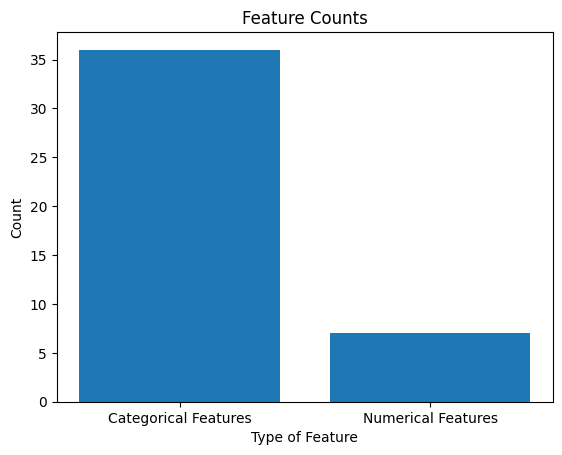

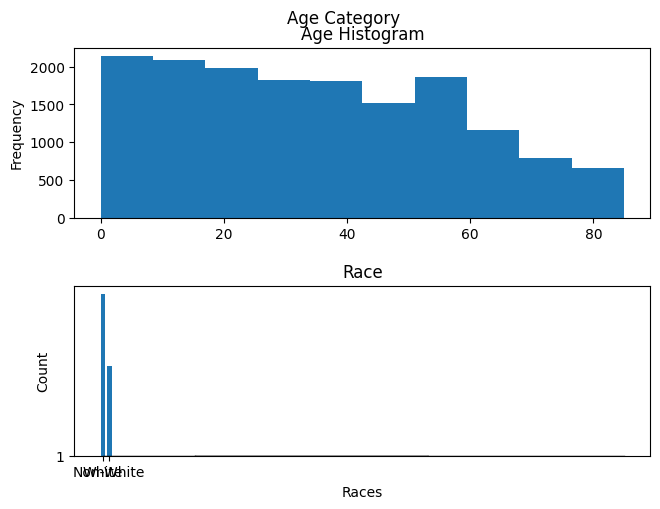

C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\930351744.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\930351744.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\930351744.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\930351744.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or

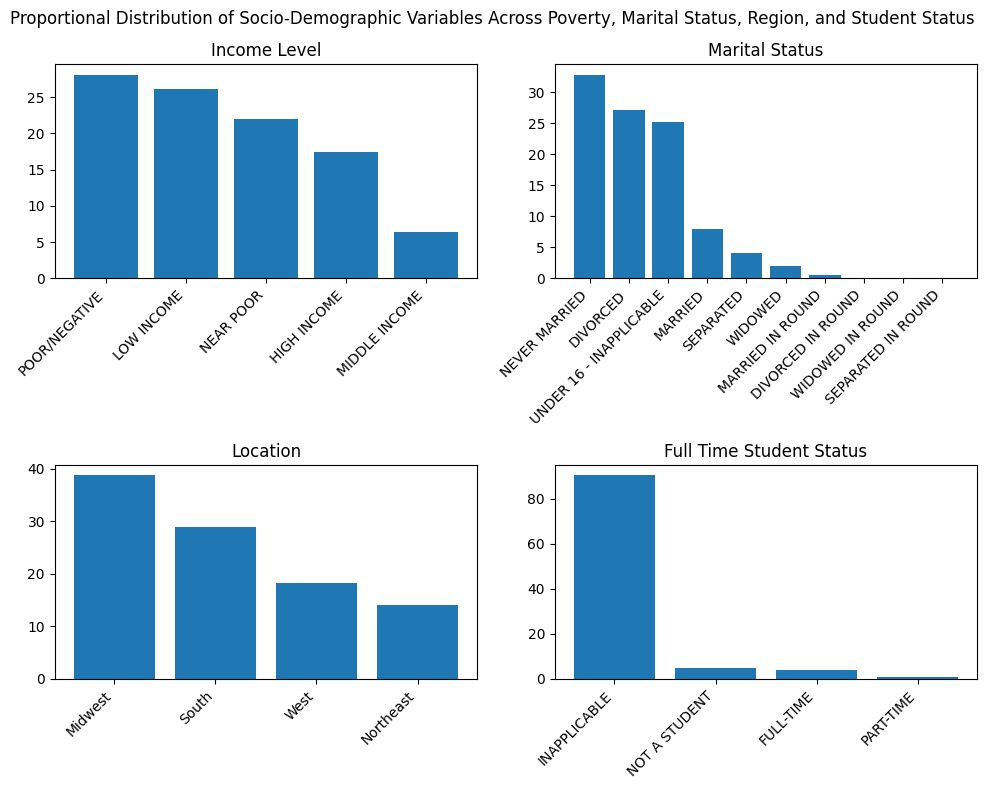

C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\930351744.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\930351744.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\930351744.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\930351744.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or

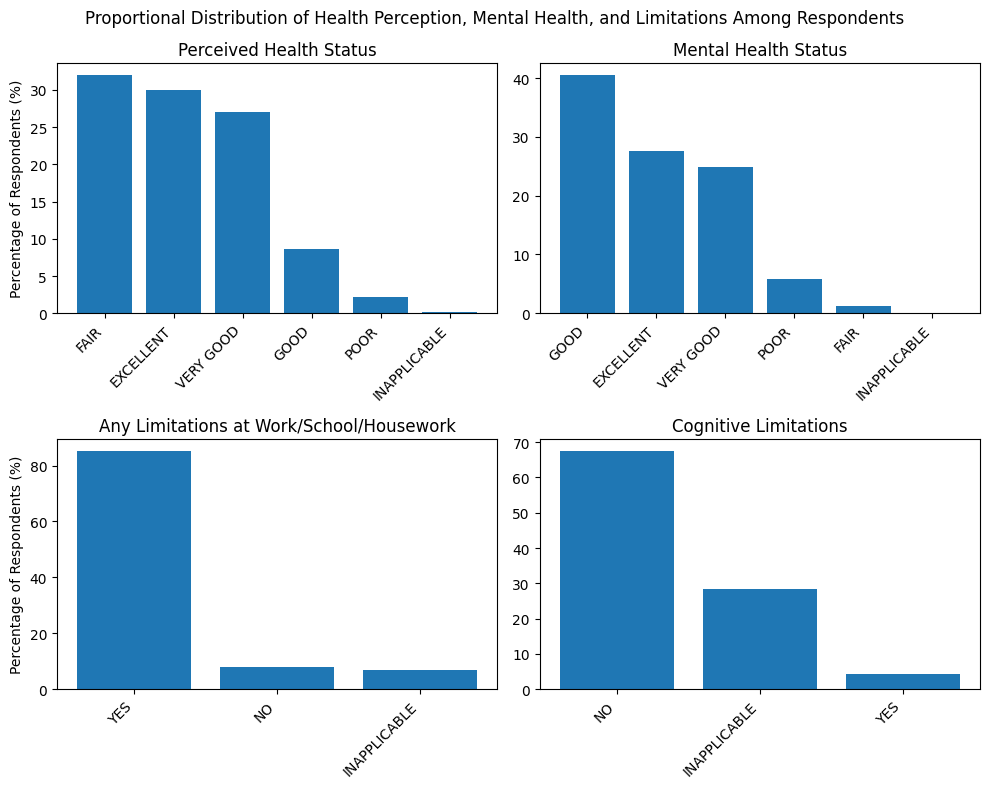

In [12]:
categorical_features = ['REGION', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'EMPST', 'POVCAT', 'INSCOV']

numerical_features = ['AGE', 'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'UTILIZATION', 'PERWT15F']
x = np.array(['Categorical Features', 'Numerical Features'])
y = np.array([len(categorical_features), len(numerical_features)])
plt.bar(x, y)
plt.title('Feature Counts')
plt.xlabel('Type of Feature')
plt.ylabel('Count')
plt.show()

fig, axs = plt.subplots(2)
fig.suptitle('Age Category')
axs[0].hist(df_panel_19['AGE'])
axs[1].boxplot(df_panel_19['AGE'], 0, 'rs', 0)
axs[1].set_title('Age Box Plot')
axs[0].set_title('Age Histogram')
axs[0].set(ylabel='Frequency')
axs[1].set(xlabel='Age')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)

x = df_panel_19_reduced['RACE'].unique()
y = df_panel_19_reduced['RACE'].value_counts().values
plt.bar(x, y)
plt.title('Race')
plt.xlabel('Races')
plt.ylabel('Count')
plt.show()


fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Increase figure size
fig.suptitle('Proportional Distribution of Socio-Demographic Variables Across Poverty, Marital Status, Region, and Student Status')

axs[0, 0].bar(df_panel_19_reduced['POVCAT'].unique(), (df_panel_19_reduced['POVCAT'].value_counts(normalize=True).values) * 100)
axs[0, 1].bar(df_panel_19_reduced['MARRY'].unique(), (df_panel_19_reduced['MARRY'].value_counts(normalize=True).values) * 100)
axs[1, 0].bar(df_panel_19_reduced['REGION'].unique(), (df_panel_19_reduced['REGION'].value_counts(normalize=True).values) * 100)
axs[1, 1].bar(df_panel_19_reduced['FTSTU'].unique(), (df_panel_19_reduced['FTSTU'].value_counts(normalize=True).values) * 100)

axs[0, 0].set_title('Income Level')
axs[0, 1].set_title('Marital Status')
axs[1, 0].set_title('Location')
axs[1, 1].set_title('Full Time Student Status')

for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.tight_layout()


plt.show()


fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Increase figure size
fig.suptitle('Proportional Distribution of Health Perception, Mental Health, and Limitations Among Respondents')

axs[0,0].bar(df_panel_19_reduced['RTHLTH'].unique(), (df_panel_19_reduced['RTHLTH'].value_counts(normalize=True).values) * 100)
axs[0,1].bar(df_panel_19_reduced['MNHLTH'].unique(), (df_panel_19_reduced['MNHLTH'].value_counts(normalize=True).values) * 100)
axs[1,0].bar(df_panel_19_reduced['ACTLIM'].unique(), (df_panel_19_reduced['ACTLIM'].value_counts(normalize=True).values) * 100)
axs[1,1].bar(df_panel_19_reduced['COGLIM'].unique(), (df_panel_19_reduced['COGLIM'].value_counts(normalize=True).values) * 100)

axs[0, 0].set_title('Perceived Health Status')
axs[0, 1].set_title('Mental Health Status')
axs[1, 0].set_title('Any Limitations at Work/School/Housework')
axs[1, 1].set_title('Cognitive Limitations')
axs[0, 0].set_ylabel('Percentage of Respondents (%)') 
axs[1, 0].set_ylabel('Percentage of Respondents (%)') 


for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.tight_layout()


plt.show()

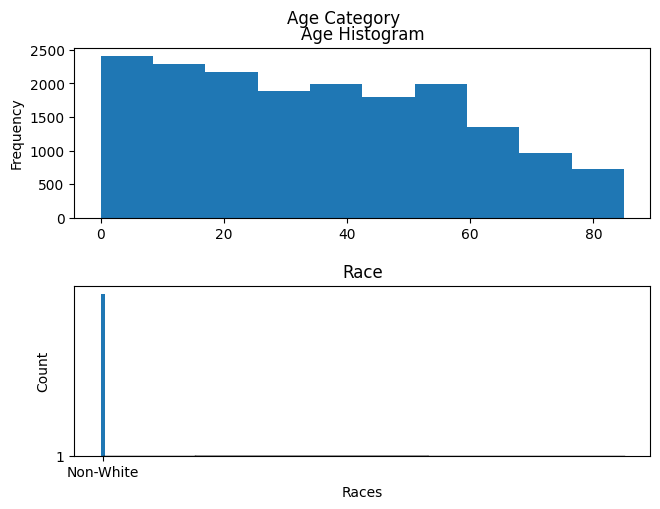

C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\432043684.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\432043684.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\432043684.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\432043684.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or

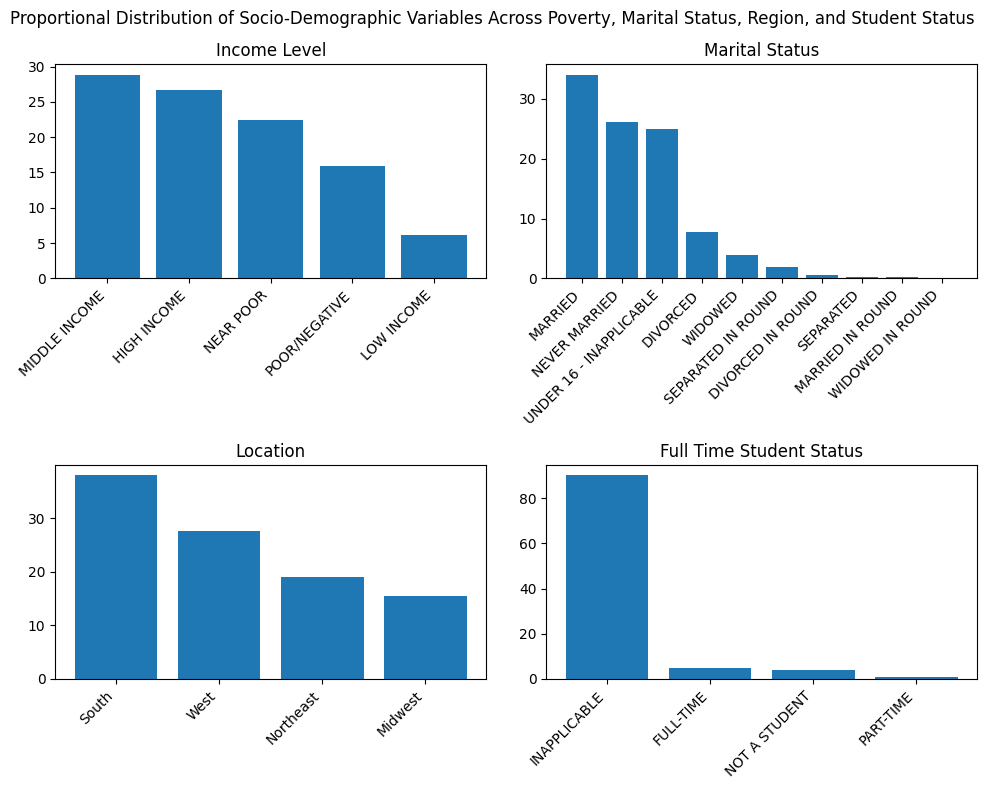

C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\432043684.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\432043684.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\432043684.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\prsal\AppData\Local\Temp\ipykernel_20040\432043684.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or

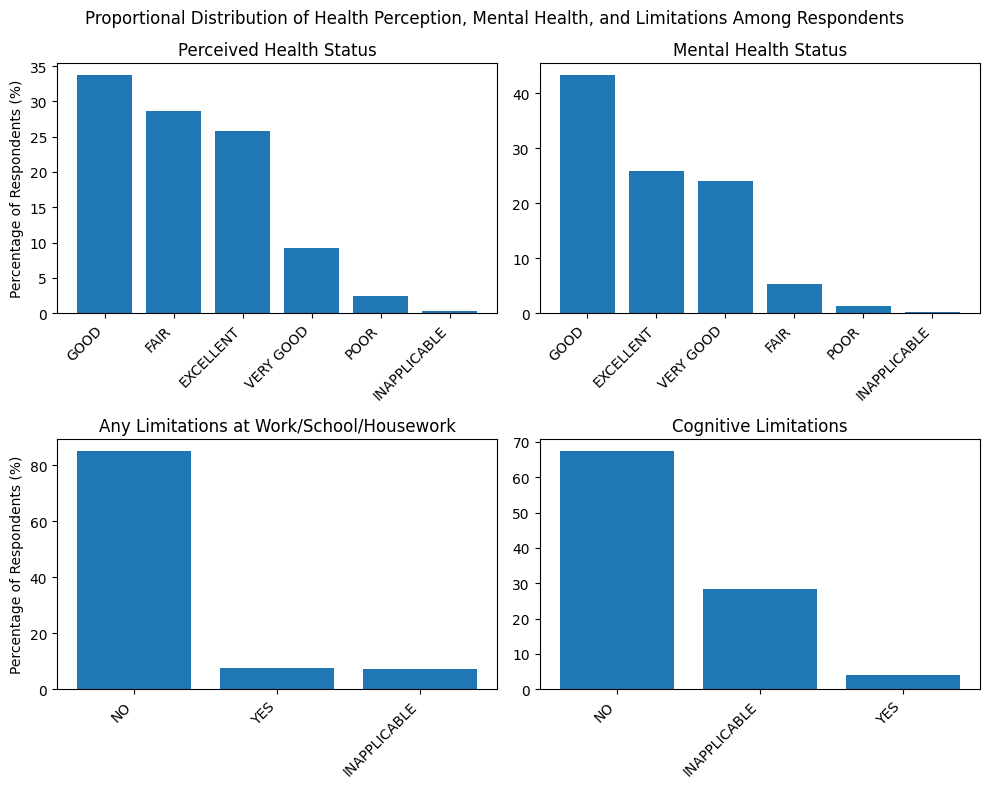

In [13]:
fig, axs = plt.subplots(2)
fig.suptitle('Age Category')
axs[0].hist(df_panel_20['AGE'])
axs[1].boxplot(df_panel_20['AGE'], 0, 'rs', 0)
axs[1].set_title('Age Box Plot')
axs[0].set_title('Age Histogram')
axs[0].set(ylabel='Frequency')
axs[1].set(xlabel='Age')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)

x = df_panel_20_reduced['RACE'].unique()
y = df_panel_20_reduced['RACE'].value_counts().values
plt.bar(x, y)
plt.title('Race')
plt.xlabel('Races')
plt.ylabel('Count')
plt.show()


fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Increase figure size
fig.suptitle('Proportional Distribution of Socio-Demographic Variables Across Poverty, Marital Status, Region, and Student Status')

axs[0, 0].bar(df_panel_20_reduced['POVCAT'].unique(), (df_panel_20_reduced['POVCAT'].value_counts(normalize=True).values) * 100)
axs[0, 1].bar(df_panel_20_reduced['MARRY'].unique(), (df_panel_20_reduced['MARRY'].value_counts(normalize=True).values) * 100)
axs[1, 0].bar(df_panel_20_reduced['REGION'].unique(), (df_panel_20_reduced['REGION'].value_counts(normalize=True).values) * 100)
axs[1, 1].bar(df_panel_20_reduced['FTSTU'].unique(), (df_panel_20_reduced['FTSTU'].value_counts(normalize=True).values) * 100)

axs[0, 0].set_title('Income Level')
axs[0, 1].set_title('Marital Status')
axs[1, 0].set_title('Location')
axs[1, 1].set_title('Full Time Student Status')

for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.tight_layout()


plt.show()


fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Increase figure size
fig.suptitle('Proportional Distribution of Health Perception, Mental Health, and Limitations Among Respondents')

axs[0,0].bar(df_panel_20_reduced['RTHLTH'].unique(), (df_panel_20_reduced['RTHLTH'].value_counts(normalize=True).values) * 100)
axs[0,1].bar(df_panel_20_reduced['MNHLTH'].unique(), (df_panel_20_reduced['MNHLTH'].value_counts(normalize=True).values) * 100)
axs[1,0].bar(df_panel_20_reduced['ACTLIM'].unique(), (df_panel_20_reduced['ACTLIM'].value_counts(normalize=True).values) * 100)
axs[1,1].bar(df_panel_20_reduced['COGLIM'].unique(), (df_panel_20_reduced['COGLIM'].value_counts(normalize=True).values) * 100)

axs[0, 0].set_title('Perceived Health Status')
axs[0, 1].set_title('Mental Health Status')
axs[1, 0].set_title('Any Limitations at Work/School/Housework')
axs[1, 1].set_title('Cognitive Limitations')
axs[0, 0].set_ylabel('Percentage of Respondents (%)') 
axs[1, 0].set_ylabel('Percentage of Respondents (%)') 


for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.tight_layout()


plt.show()

In [14]:
df_panel_19_reduced['PERWT15F'].describe()


count    15830.000000
mean      8930.337369
std       8521.260446
min          0.000000
25%       3428.548713
50%       6146.458935
75%      11749.810086
max      94264.071559
Name: PERWT15F, dtype: float64

#### 2.3 Outlier Detection and Handling

In [15]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [16]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

In [17]:
null_cols = df_panel_19_reduced.isnull().sum()
print('Rows with null values:')
null_cols[null_cols > 0]

Rows with null values:


Series([], dtype: int64)

In [18]:
null_cols = df_panel_20_reduced.isnull().sum()
print('Rows with null values:')
null_cols[null_cols > 0]

Rows with null values:


Series([], dtype: int64)

Looks like no Null values.

In [19]:
def get_df_mappings(df, print_fails=False):
    all_mappers = {}
    failed_col_mappers = []
    for col in df.columns:
        mapper = parse_codebook_table_by_column(col)

        if not len(mapper):
            failed_col_mappers.append(col)
            if print_fails:
                print(f'{col} : failed to extract mapping')
            continue

        all_mappers[col] = mapper
        
    return all_mappers, failed_col_mappers

In [20]:
all_mappers_19, failed_col_mappers_19 = get_df_mappings(df_panel_19_reduced)
failed_col_mappers_19

Failed to locate mapper for: RACE
Failed to locate mapper for: UTILIZATION
Failed to locate mapper for: PERWT15F


['RACE', 'UTILIZATION', 'PERWT15F']

In [21]:
all_mappers_20, failed_col_mappers_20 = get_df_mappings(df_panel_20_reduced)
failed_col_mappers_20

Failed to locate mapper for: RACE
Failed to locate mapper for: UTILIZATION
Failed to locate mapper for: PERWT15F


['RACE', 'UTILIZATION', 'PERWT15F']

In [22]:
# Iterate over each column in each dataset and use the mapper to identify columns that can't be mapped
def identify_columns_with_unmappable_values(df, mapper):
    failed_mappable_columns = set()
    for col in df.columns:
        unique_vals = df[col].unique()
        if col in mapper:
            for val in unique_vals:
                if str(val) not in mapper[col]:
                    failed_mappable_columns.add(col)
                    
    return failed_mappable_columns

In [23]:
unmappable_19_cols = identify_columns_with_unmappable_values(df_panel_19_reduced, all_mappers_19)
print('Columns in panel19 that couldn\'t be mapped')
unmappable_19_cols

Columns in panel19 that couldn't be mapped


{'AGE', 'HONRDC', 'K6SUM42', 'MCS42', 'PCS42', 'PHQ242'}

In [24]:
unmappable_20_cols = identify_columns_with_unmappable_values(df_panel_20_reduced, all_mappers_20)
print('Columns in panel20 that couldn\'t be mapped')
unmappable_20_cols

Columns in panel20 that couldn't be mapped


{'AGE', 'HONRDC', 'K6SUM42', 'MCS42', 'PCS42', 'PHQ242'}

In [25]:
# #### First let's inspect the columns that weren't found in the codebook

def visualize_cols_distributions(df):
    num_columns = len(df.columns)
    
    figsize = (15, num_columns * 2)
    # Create a figure with a specified number of subplots
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=figsize)

    if num_columns == 1:
        axes = [axes]
    
    for i, col in enumerate(df.columns):
        axes[i].set_title(col)

        sns.stripplot(x=df[col], ax=axes[i], orient='h', jitter=True)
        
#     plt.tight_layout()
    plt.subplots_adjust(hspace=2)  # Change this value to increase/decrease spacing
    # Show the plot
    plt.show()

### Columns from panel 19 that couldn't get mapped

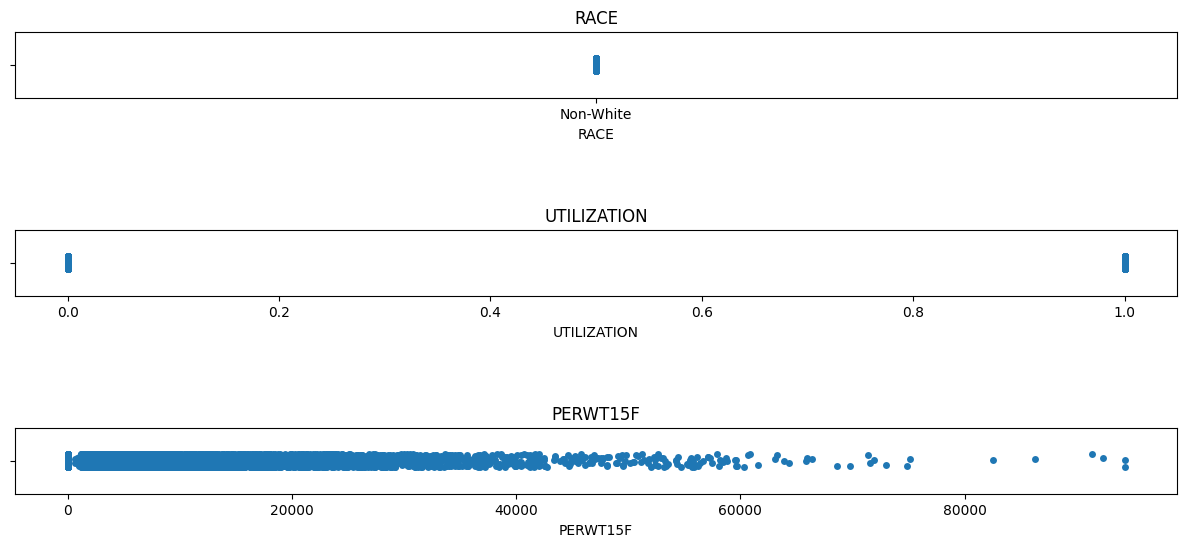

In [26]:
visualize_cols_distributions(df_panel_19_reduced[list(failed_col_mappers_19)])

### Columns from panel 20 that couldn't get mapped

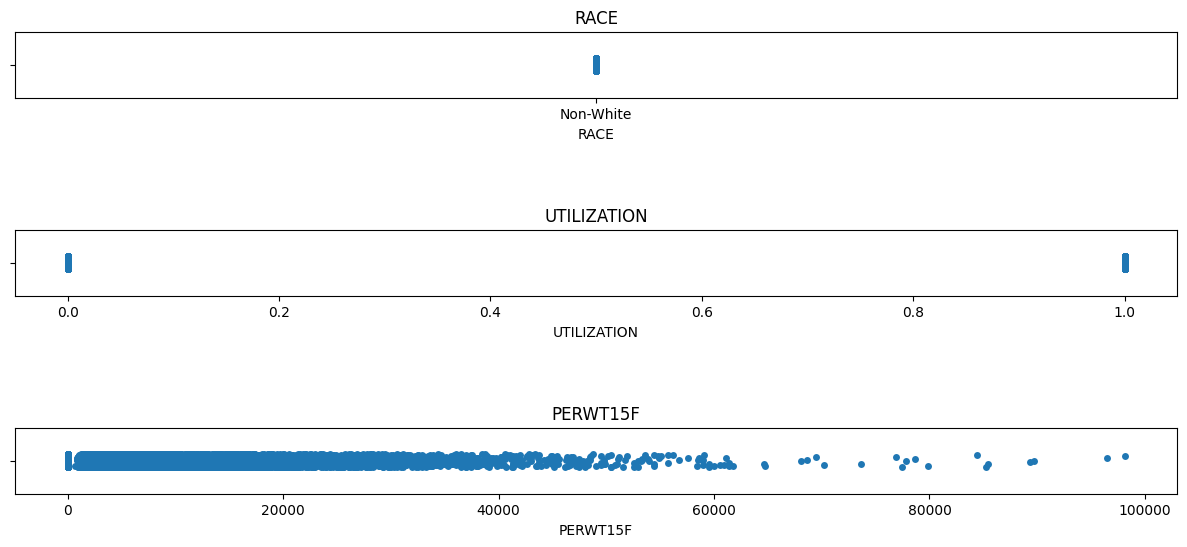

In [27]:
visualize_cols_distributions(df_panel_20_reduced[list(failed_col_mappers_20)])


##### It looks like Race and Utilization seem to follow an enumerated schema, but PERWT15F doesn't and it is worth investigating more

In [28]:
def scatter_boxplot_overlay(data, x_col):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
    plt.subplots_adjust(hspace=1)
    
    axes[0].set_title(x_col)
    sns.histplot(data[x_col], kde=False, ax=axes[0], color='blue', bins=300, alpha=0.7)
        
    axes[1].set_title(f'{x_col} (log transformed)')
    log_data= np.log(data[x_col] + 1)
    sns.histplot(log_data ,ax=axes[1], kde=False, color='red', bins=300, alpha=0.7)
    
    # compute standard deviation ranges
    log_std = np.std(log_data)
    log_mean = np.mean(log_data)

    # we know that 99% of the data should lie within 3 stddevs
    for i in range(3):
        left, right = log_mean - ((i+1) * log_std), log_mean + ((i+1) * log_std) 
        axes[1].fill_betweenx(
                        [0, 600], 
                        left, right, color='green', alpha=0.3
                    )
        
        # we only care about right side of data outliers
        num_outliers = (log_data > right).sum()
        print(f'Number of data points outside right {i+1} stddev bound: {num_outliers}')
        
    plt.show()

#### Analyzing distribution of PERWT15F panel 19

Number of data points outside right 1 stddev bound: 312
Number of data points outside right 2 stddev bound: 0
Number of data points outside right 3 stddev bound: 0


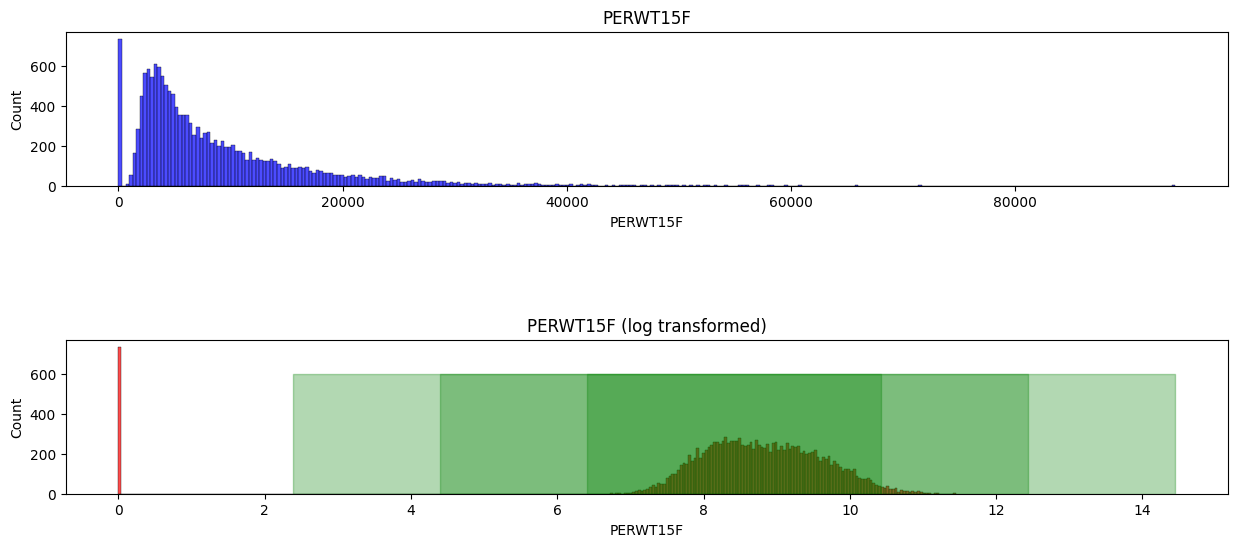

In [29]:
scatter_boxplot_overlay(df_panel_19_reduced, 'PERWT15F')

#### Analyzing distribution of PERWT15F panel 20

Number of data points outside right 1 stddev bound: 448
Number of data points outside right 2 stddev bound: 0
Number of data points outside right 3 stddev bound: 0


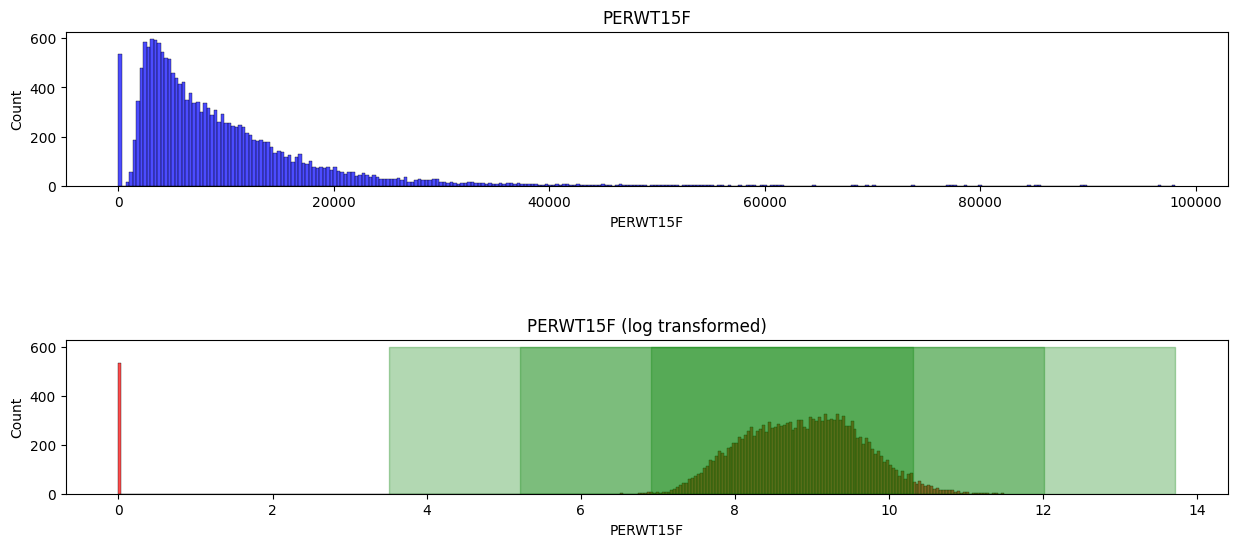

In [30]:
scatter_boxplot_overlay(df_panel_20_reduced, 'PERWT15F')

##### It appears that the values found in these additional columns align with our expections and after trying to identify and concerning outliers we have failed. Nice!

#### Now let's inspect the columns that had values that were failed to map using the codebook

In [31]:
### examine panel 19
for col in unmappable_19_cols:
    print(col, ':', all_mappers_19[col], '\n')


PHQ242 : {'-9': 'NOT ASCERTAINED', '-1': 'INAPPLICABLE', '0 - 6': 'RATING OF LAST 2 WEEKS'} 

HONRDC : {'-9': 'NOT ASCERTAINED', '-8': 'DK', '-7': 'REFUSED', '-1': 'INAPPLICABLE', '1': 'YES - HONORABLY DISCHARGED', '2': 'NO - NOT HONORABLY DISCHARGED', '3 16': 'OR YOUNGER - INAPPLICABLE', '4': 'NOW ACTIVE DUTY'} 

PCS42 : {'-9': 'NOT ASCERTAINED', '-1': 'INAPPLICABLE', '4.41 - 72.07': ''} 

K6SUM42 : {'-9': 'NOT ASCERTAINED', '-1': 'INAPPLICABLE', '0 - 24': 'RATING OF LAST 30 DAYS'} 

MCS42 : {'-9': 'NOT ASCERTAINED', '-1': 'INAPPLICABLE', '0.05 - 75.51': ''} 

AGE : {'-1': 'INAPPLICABLE', '0 - 4': 'AGE', '5 - 17': 'AGE', '18 - 24': 'AGE', '25 - 44': 'AGE', '45 - 64': 'AGE', '65 - 85': 'AGE'} 



In [32]:
df_panel_19_reduced[list(unmappable_19_cols)].describe()


,PHQ242,HONRDC,PCS42,K6SUM42,MCS42,AGE
count,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000
mean,-0.003853,2.224889,29.358455,1.274289,30.851517,35.090461
std,1.278136,0.512242,25.996522,3.955331,26.968146,22.475549
min,-1.000000,1.000000,-9.000000,-9.000000,-9.000000,0.000000
25%,-1.000000,2.000000,-1.000000,-1.000000,-1.000000,15.000000
50%,0.000000,2.000000,39.505000,0.000000,42.480000,33.000000
75%,0.000000,3.000000,54.800000,2.000000,56.580000,53.000000
max,6.000000,4.000000,72.070000,24.000000,75.510000,85.000000


In [33]:
import re

def visualize_cols_distributions_with_mapper(df, mapper):
    num_columns = len(df.columns)
    
    figsize = (15, num_columns * 2)
    # Create a figure with a specified number of subplots
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=figsize)

    if num_columns == 1:
        axes = [axes]
    
    for i, col in enumerate(df.columns):
        axes[i].set_title(col)
        
        sns.stripplot(x=df[col], ax=axes[i], orient='h', jitter=True)
        
        vlines = []
        for key, value in mapper[col].items():
            matches = re.findall(r"-?\d+(?:\.\d+)?", key)
            vlines.append([float(match) if '.' in match else int(match) for match in matches])

        for line in vlines:
            if len(line) == 1:
                axes[i].axvline(x=line[0], color='g', linestyle='--')
            elif len(line) == 2:
                axes[i].fill_betweenx(
                    [-1, 1], 
                    line[0], line[1], color='green', alpha=0.3
                )
    
    plt.subplots_adjust(hspace=2)
    
    plt.show()

#### Analyzing columns that had values that couldn't be mapped using the codebook in panel 19

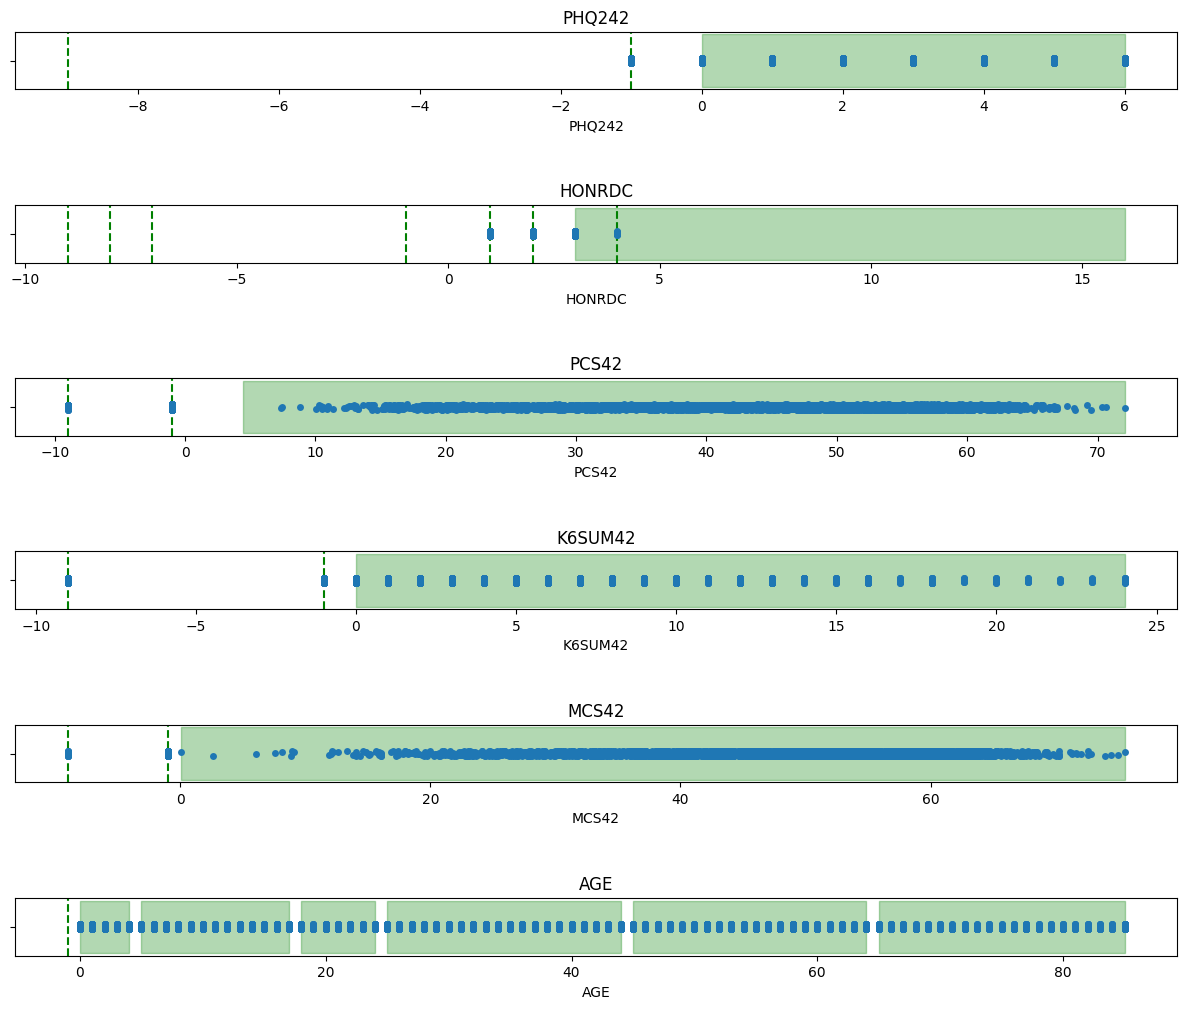

In [34]:
visualize_cols_distributions_with_mapper(df_panel_19_reduced[list(unmappable_19_cols)], all_mappers_19)


#### Analyzing columns that had values that couldn't be mapped using the codebook in panel 19

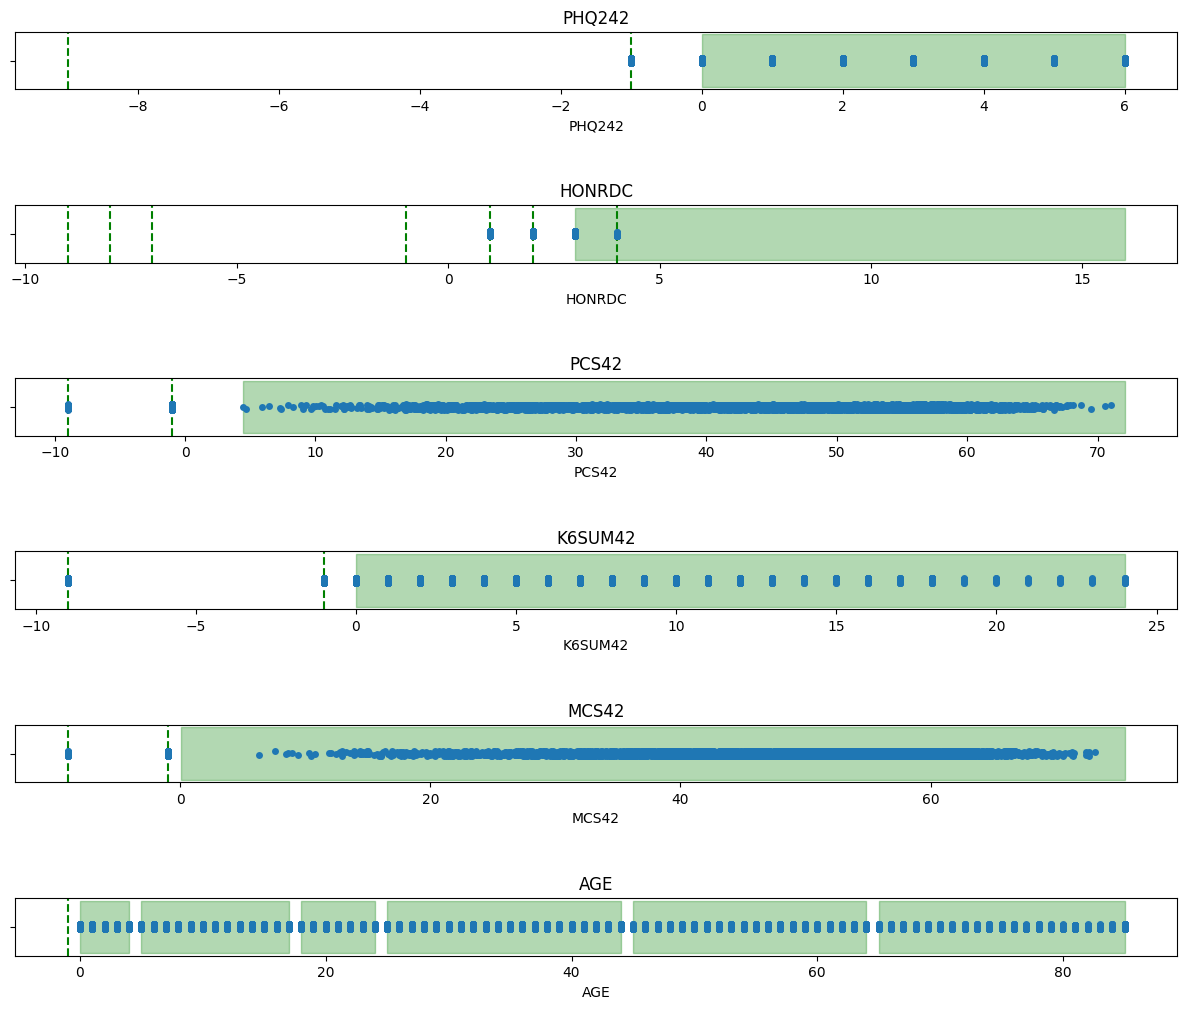

In [35]:
visualize_cols_distributions_with_mapper(df_panel_20_reduced[list(unmappable_20_cols)], all_mappers_20)


##### It looks like the reason why these colums couldn't get mapped was because they included numerical ranges of values but all of the values we are seeing lie within the ranges/values defined in the codemapper


#### 2.4 Correlation Analysis

<Axes: >

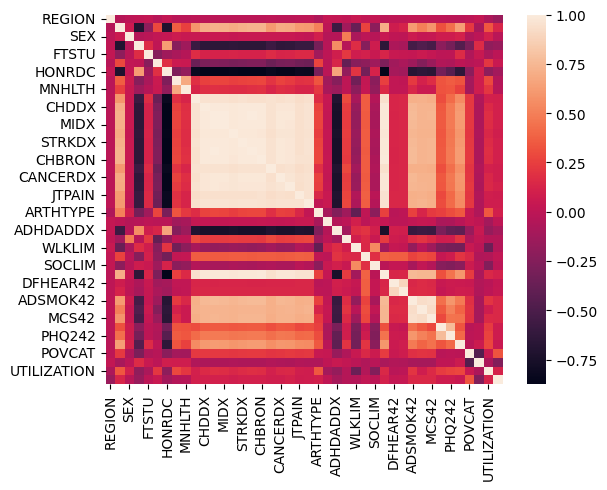

In [36]:
# Preliminary data visualizations
# Correlation plots
numerCol = df_panel_19_reduced.select_dtypes("number")
corr= numerCol.corr()
sns.heatmap(corr)



<Axes: >

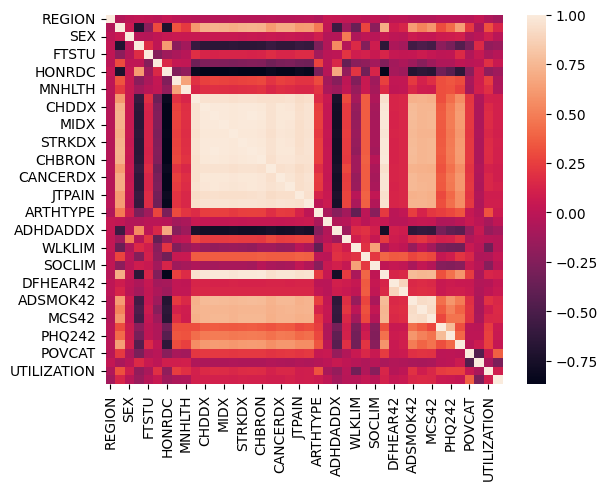

In [37]:
numerCol = df_panel_20_reduced.select_dtypes("number")
corr= numerCol.corr()
sns.heatmap(corr)

In [38]:
import scipy.stats as stats

# Create a contingency table
contingency_table = pd.crosstab(df_panel_19_reduced['RACE'], df_panel_19_reduced['UTILIZATION'])

# Perform the Chi-Square test of independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Display the results
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

Contingency Table:
UTILIZATION      0     1
RACE                    
Non-White    13112  2718

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[13112.  2718.]]


In [39]:
# Create a contingency table
contingency_table = pd.crosstab(df_panel_20_reduced['RACE'], df_panel_20_reduced['UTILIZATION'])

# Perform the Chi-Square test of independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Display the results
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

Contingency Table:
UTILIZATION      0     1
RACE                    
Non-White    14546  3024

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[14546.  3024.]]


#### 2.5 Other analysis

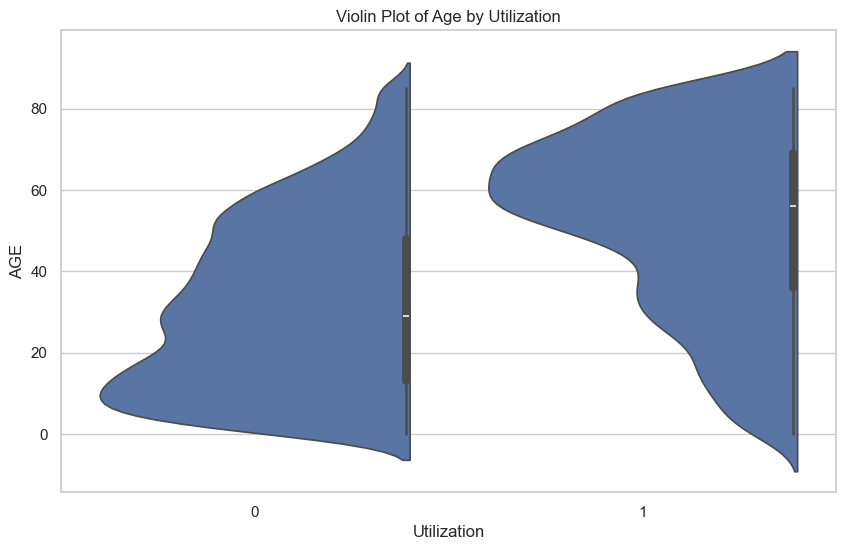

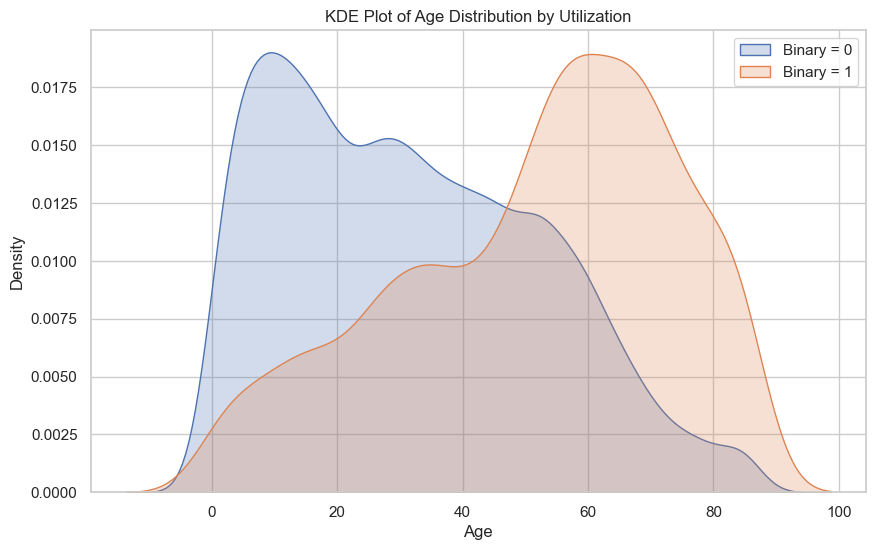

In [40]:
sns.set_theme(style="whitegrid")

# 2. Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='UTILIZATION', y='AGE', data=df_panel_19_reduced, split=True)
plt.title('Violin Plot of Age by Utilization')
plt.xlabel('Utilization')
plt.ylabel('AGE')
plt.show()

# 3. Overlaid KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_panel_19_reduced[df_panel_19_reduced['UTILIZATION'] == 0]['AGE'], label='Binary = 0', fill=True)
sns.kdeplot(df_panel_19_reduced[df_panel_19_reduced['UTILIZATION'] == 1]['AGE'], label='Binary = 1', fill=True)
plt.title('KDE Plot of Age Distribution by Utilization')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

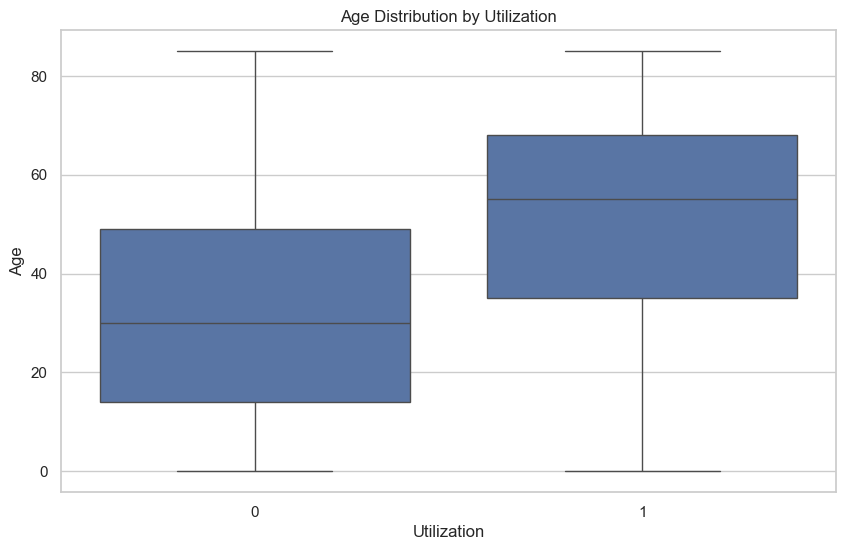

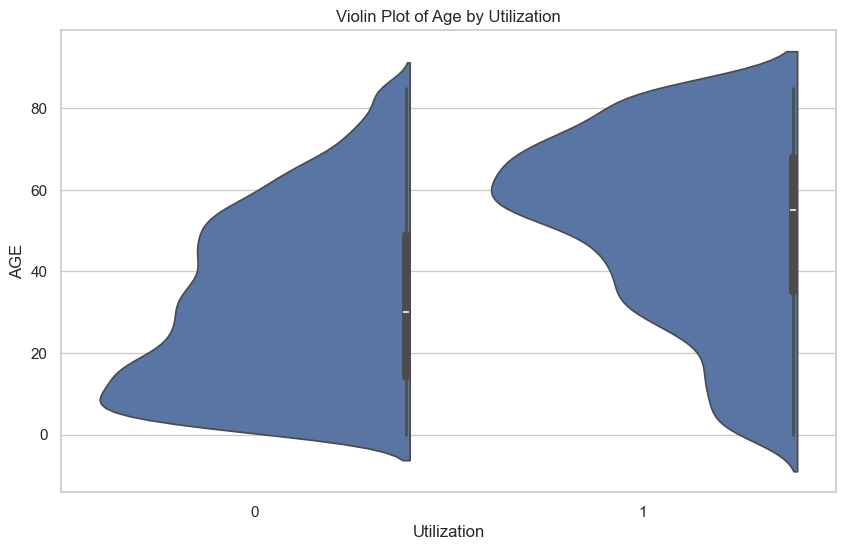

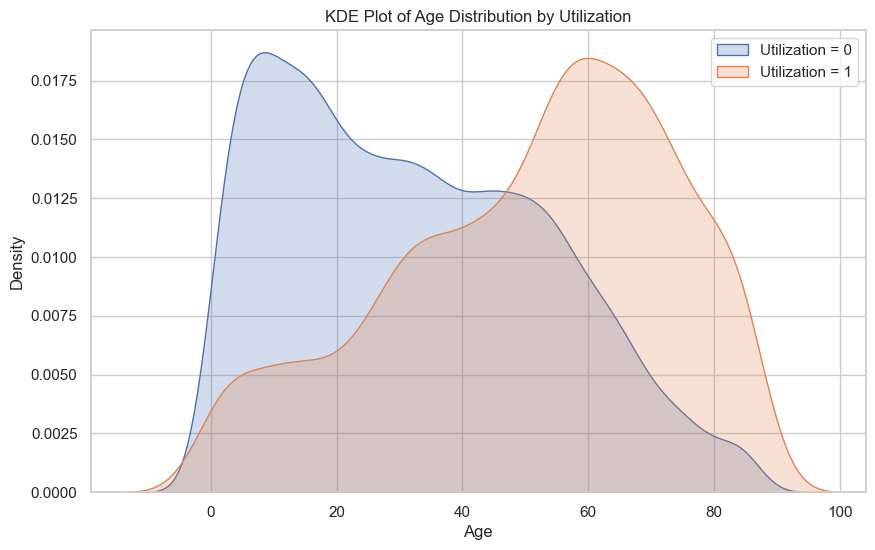

In [41]:
# 1. Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='UTILIZATION', y='AGE', data=df_panel_20_reduced)
plt.title('Age Distribution by Utilization')
plt.xlabel('Utilization')
plt.ylabel('Age')
plt.show()

# 2. Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='UTILIZATION', y='AGE', data=df_panel_20_reduced, split=True)
plt.title('Violin Plot of Age by Utilization')
plt.xlabel('Utilization')
plt.ylabel('AGE')
plt.show()

# 3. Overlaid KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_panel_20_reduced[df_panel_20_reduced['UTILIZATION'] == 0]['AGE'], label='Utilization = 0', fill=True)
sns.kdeplot(df_panel_20_reduced[df_panel_20_reduced['UTILIZATION'] == 1]['AGE'], label='Utilization = 1', fill=True)
plt.title('KDE Plot of Age Distribution by Utilization')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

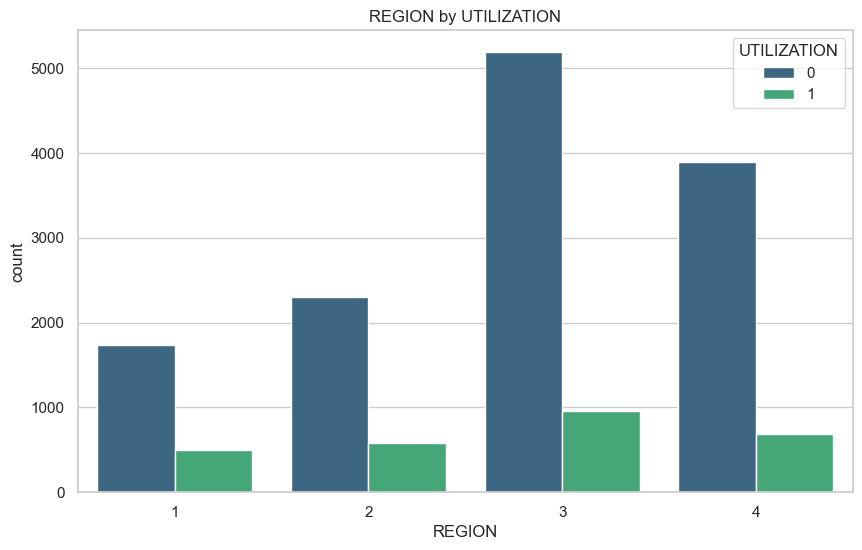

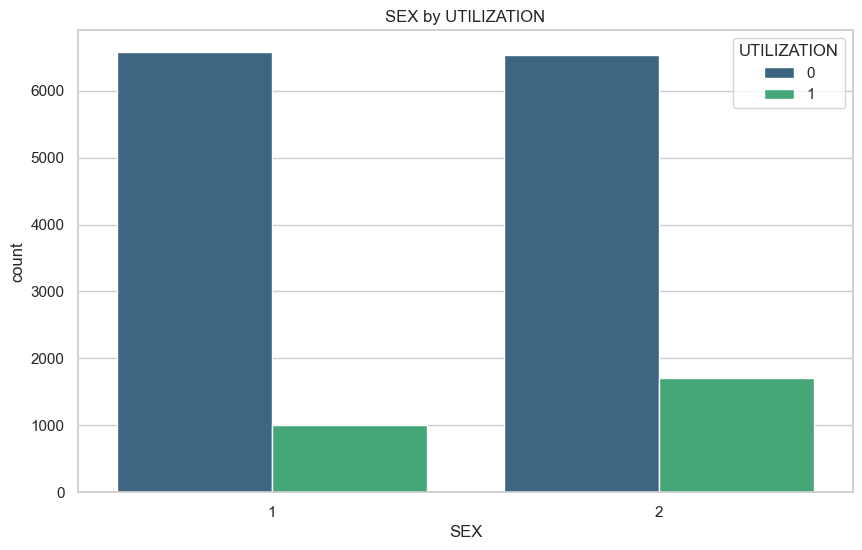

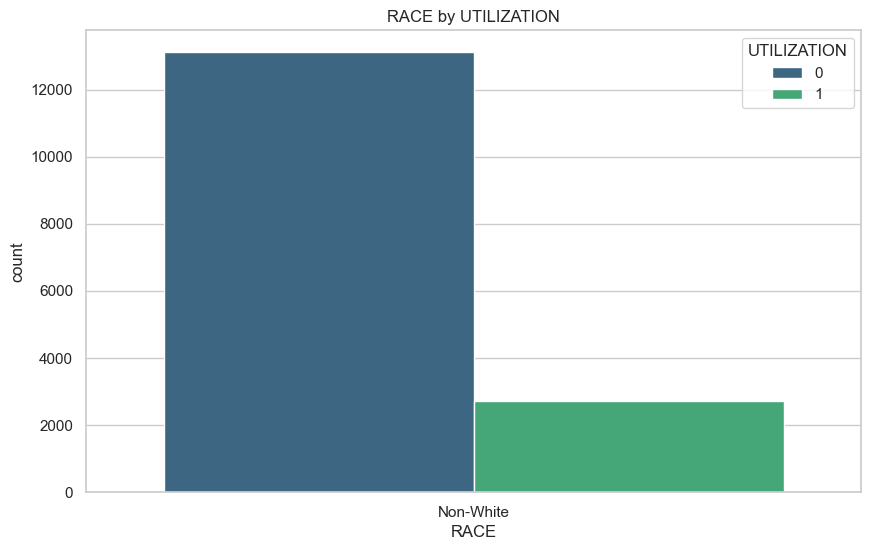

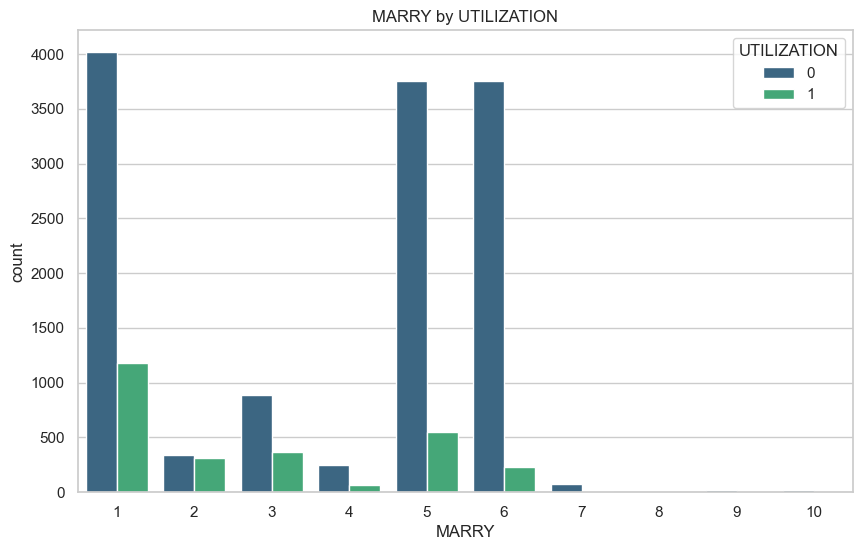

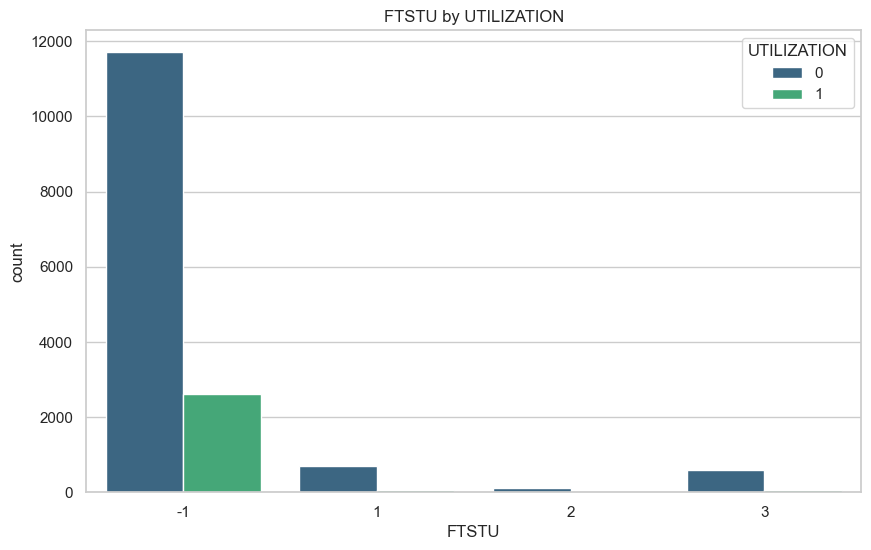

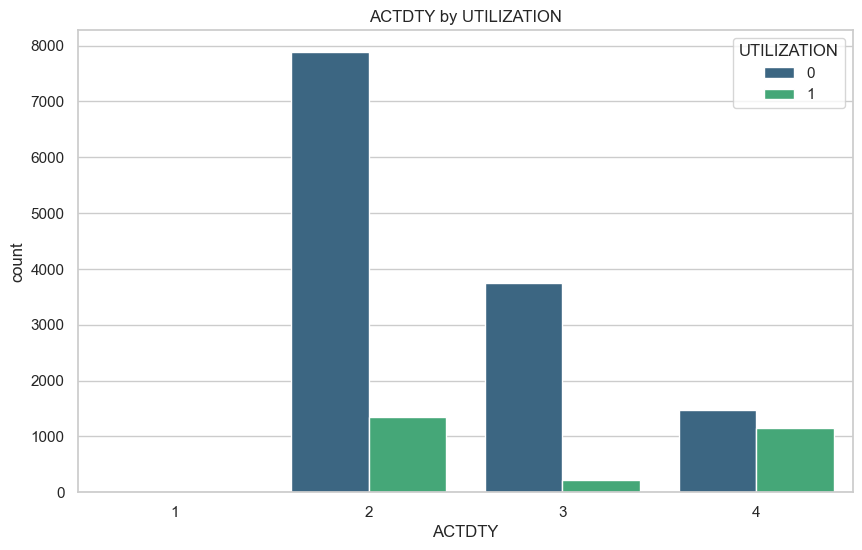

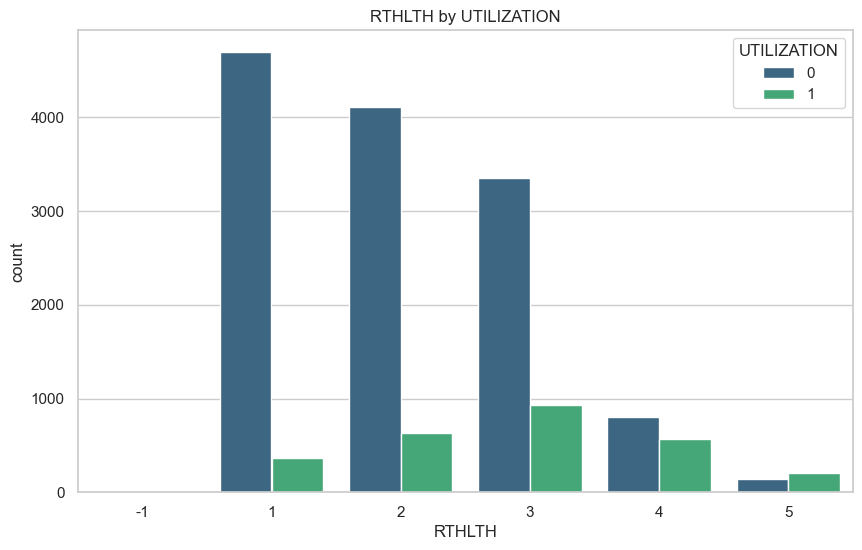

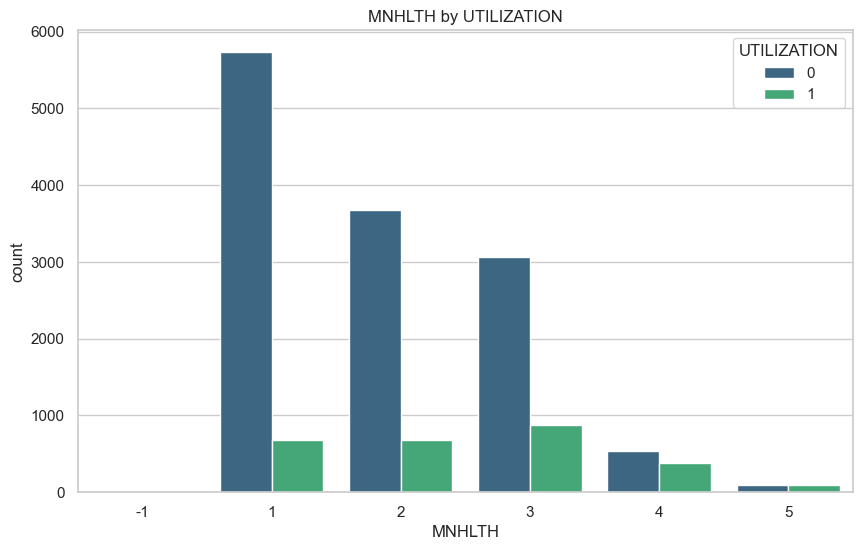

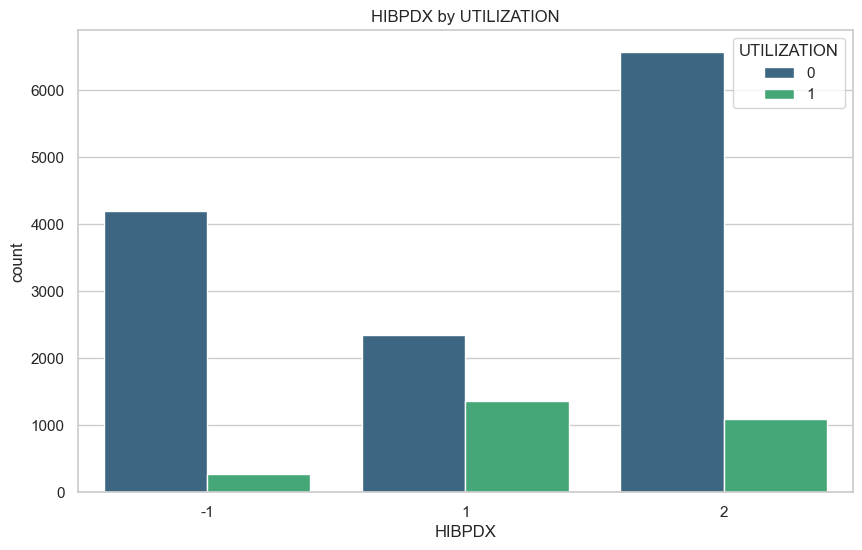

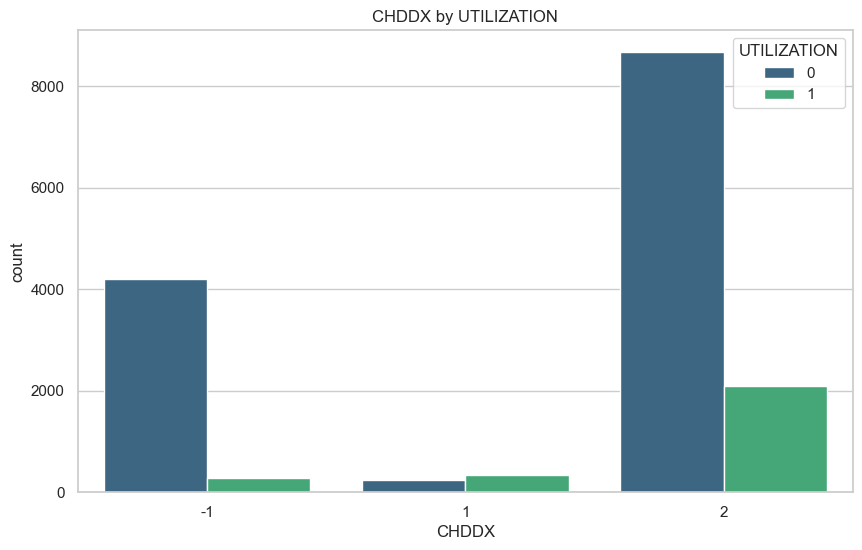

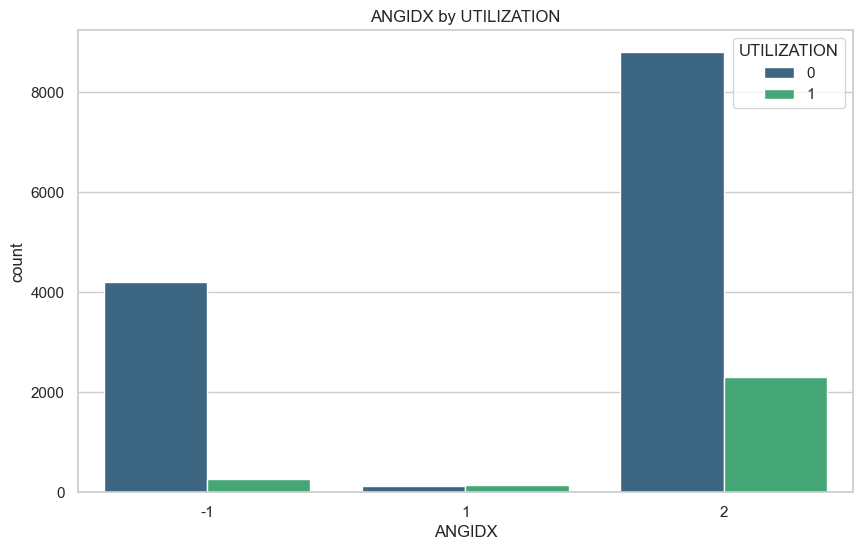

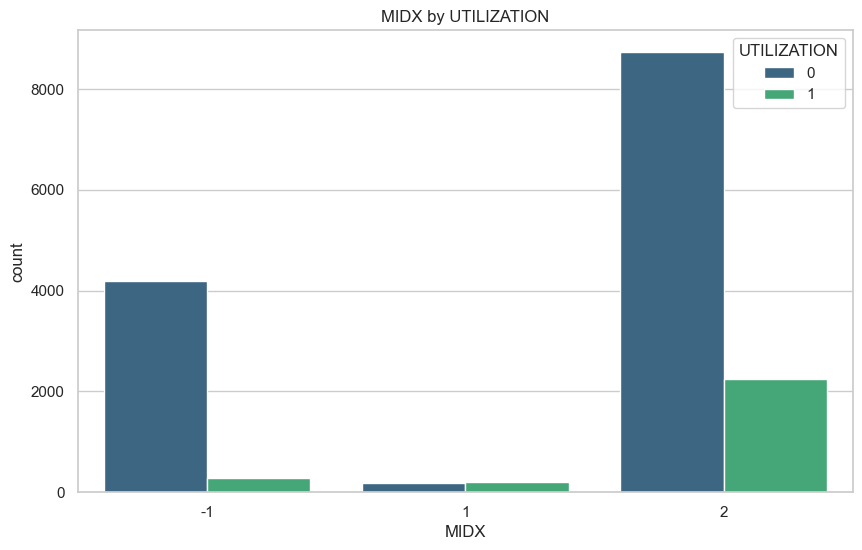

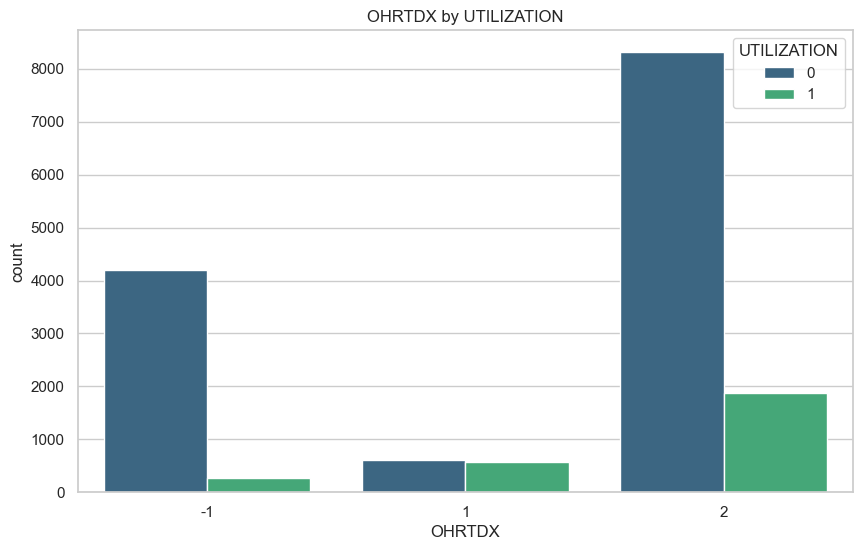

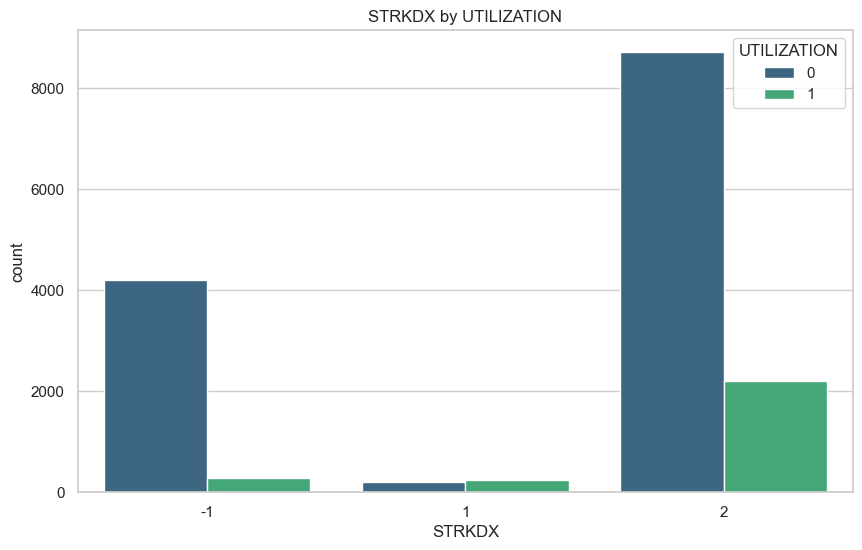

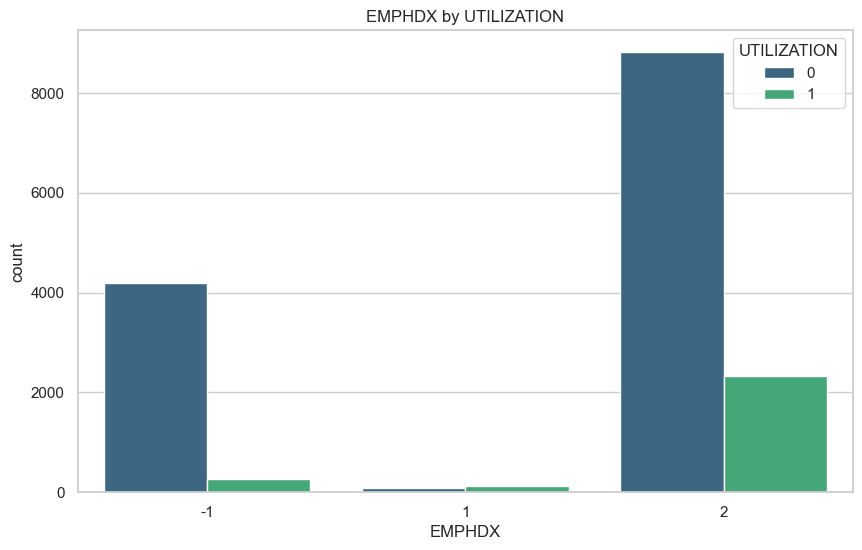

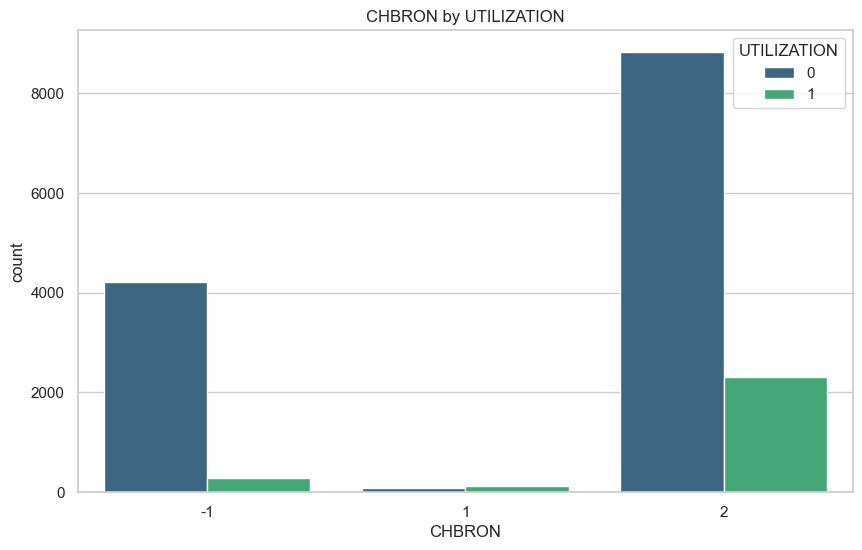

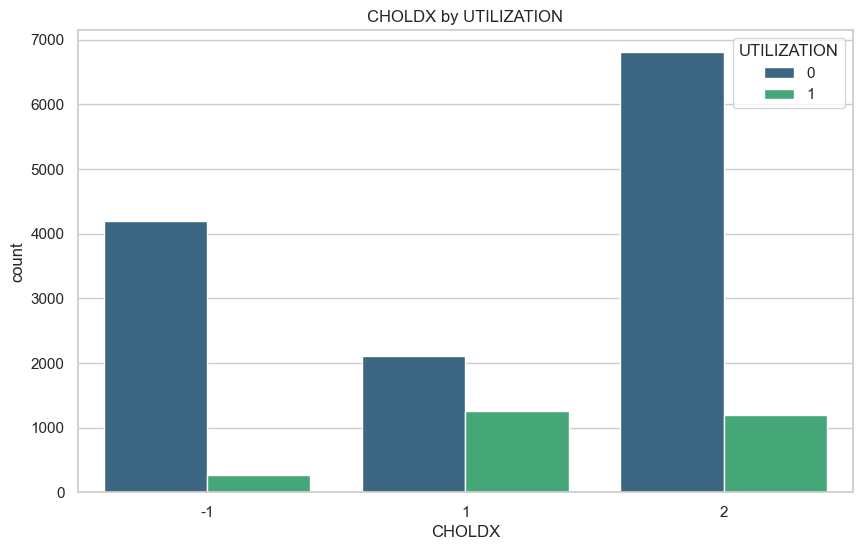

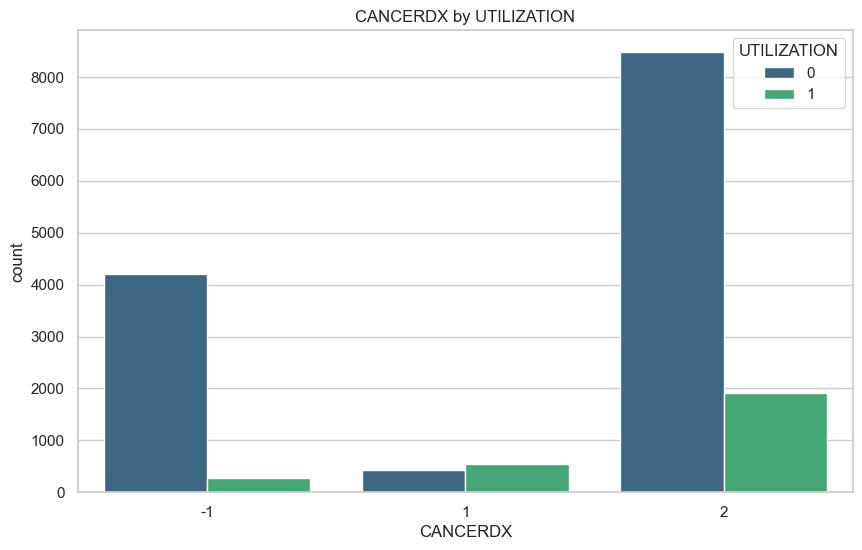

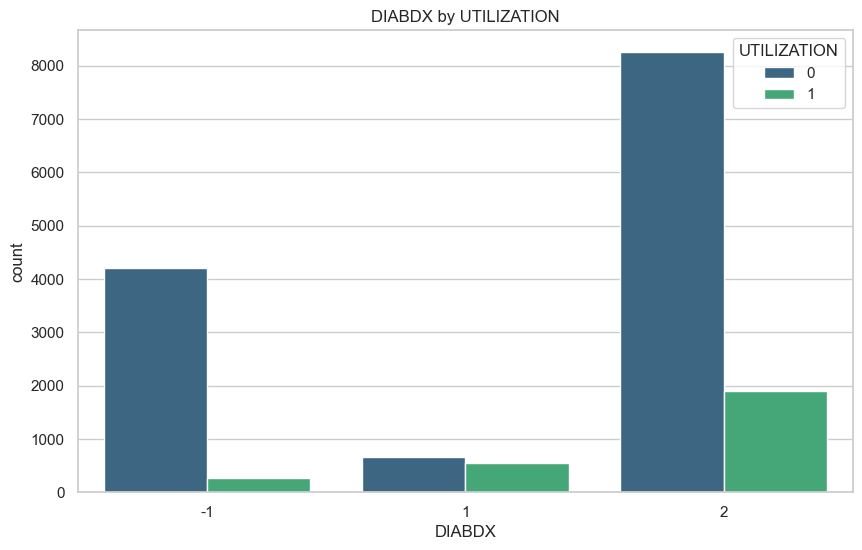

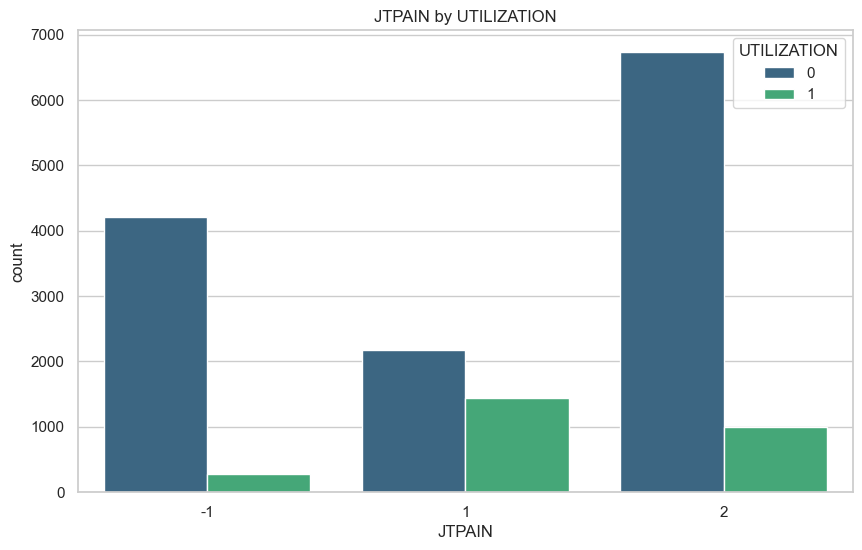

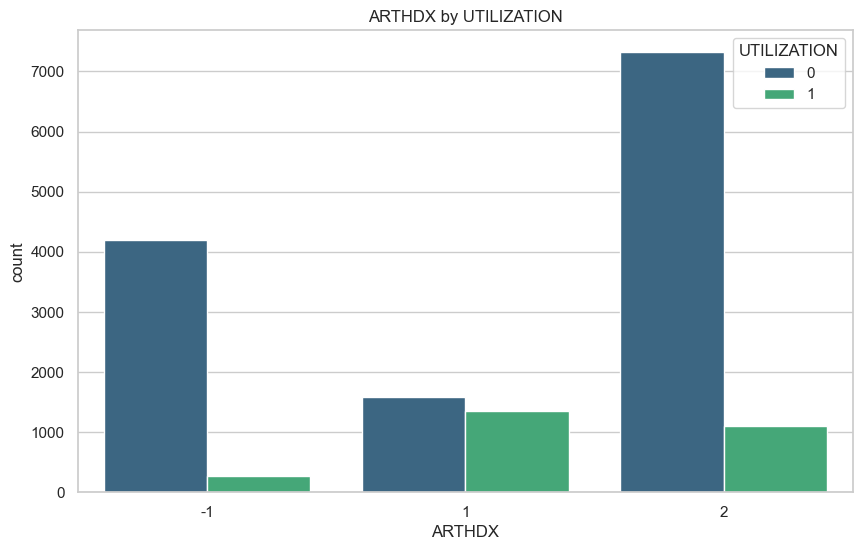

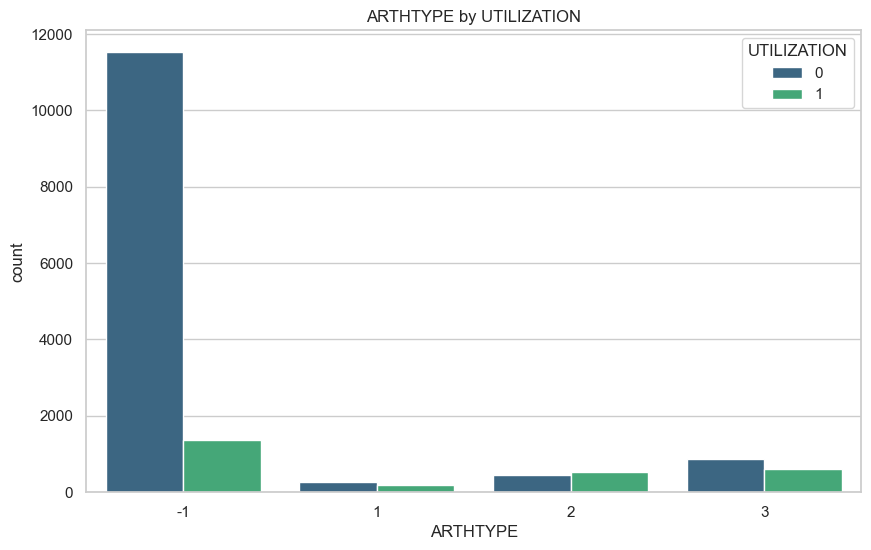

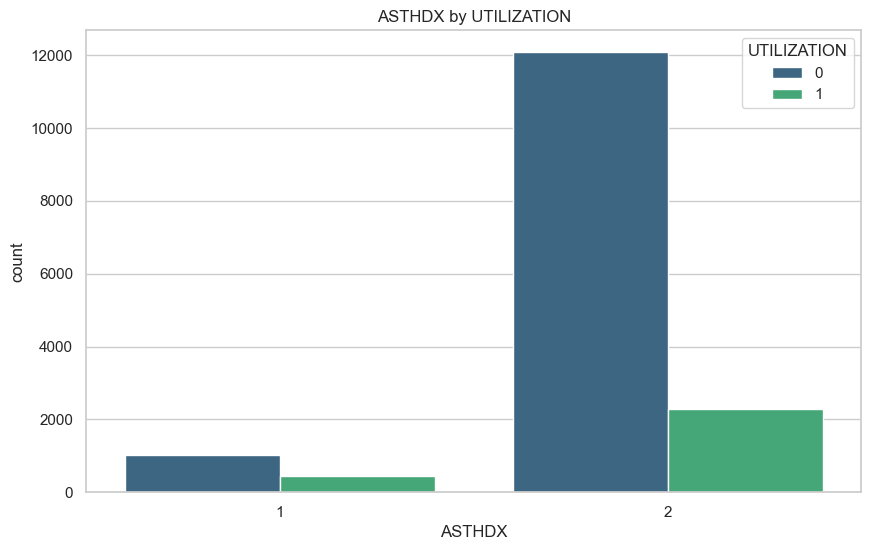

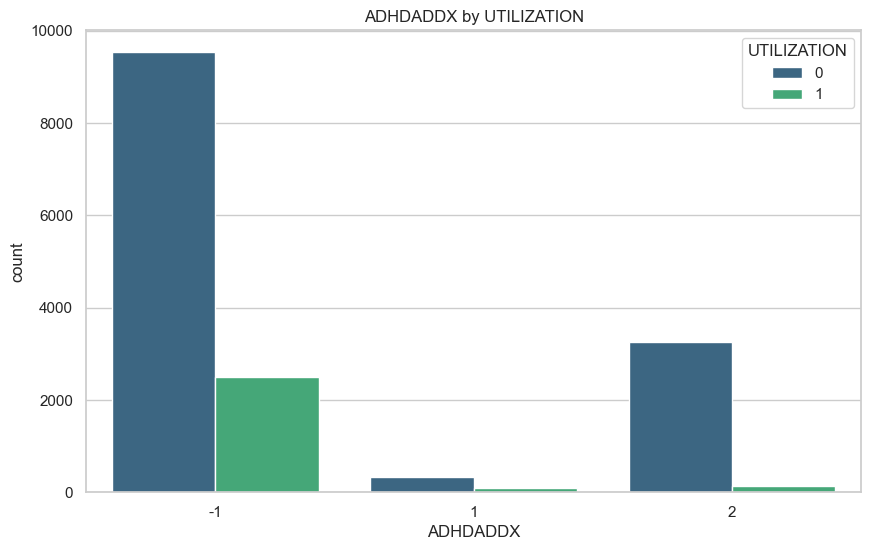

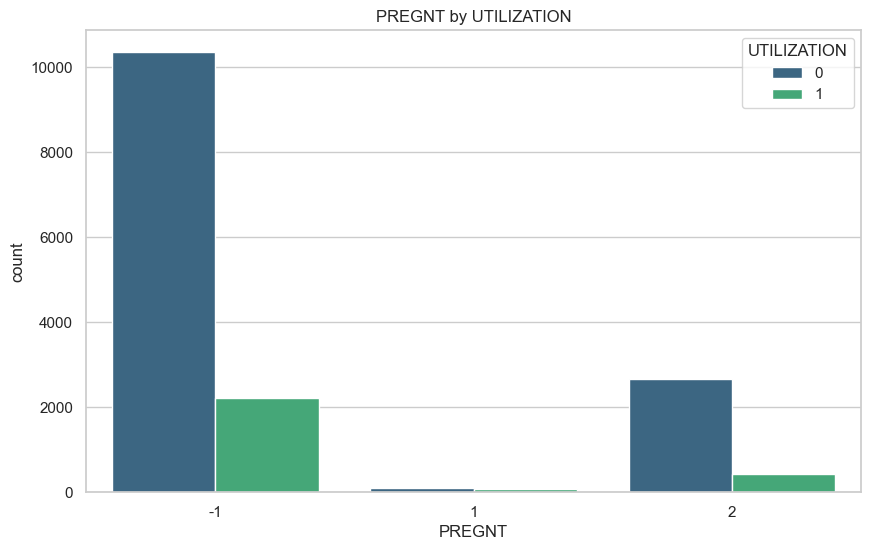

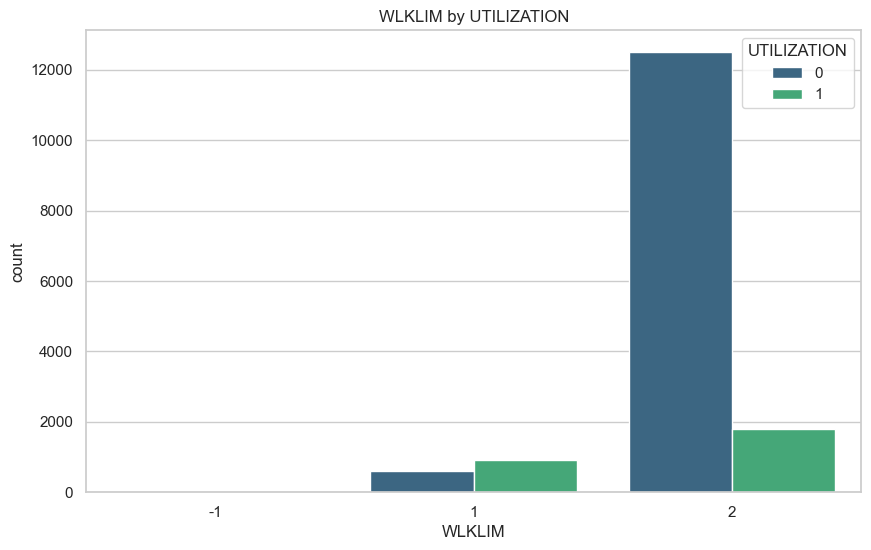

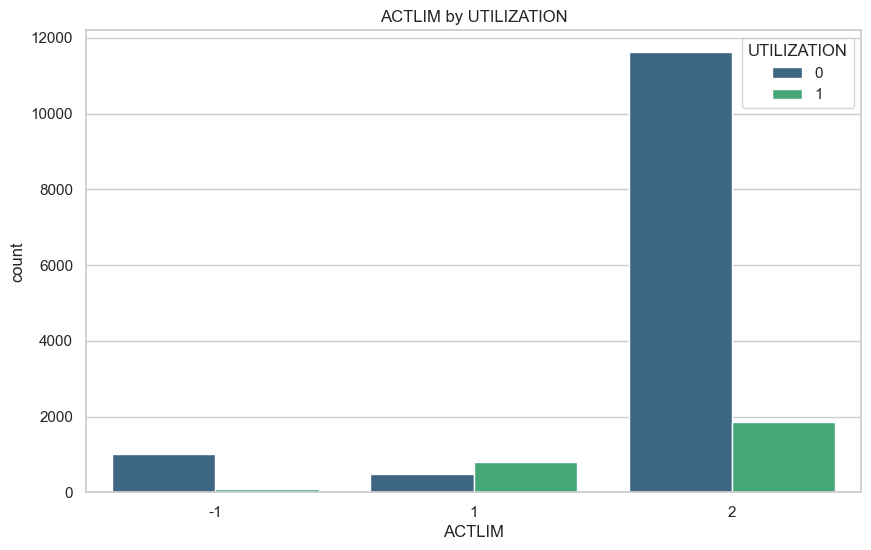

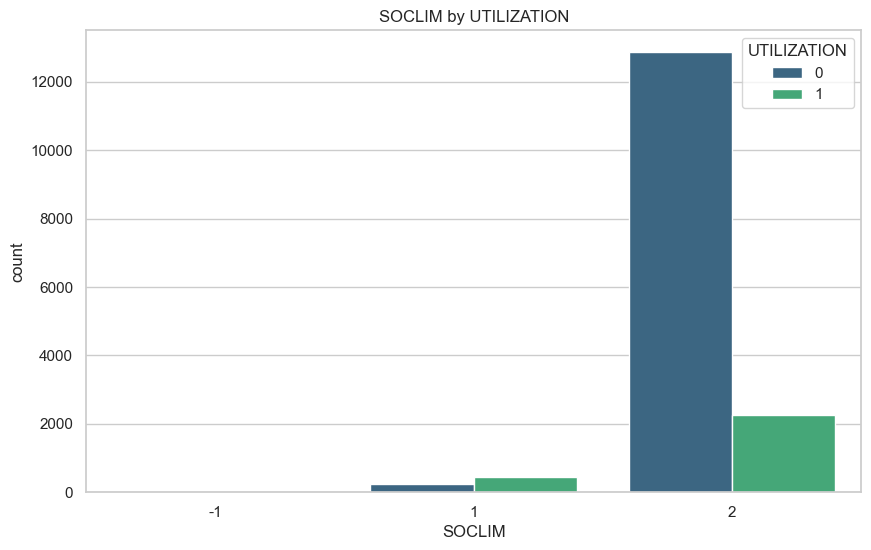

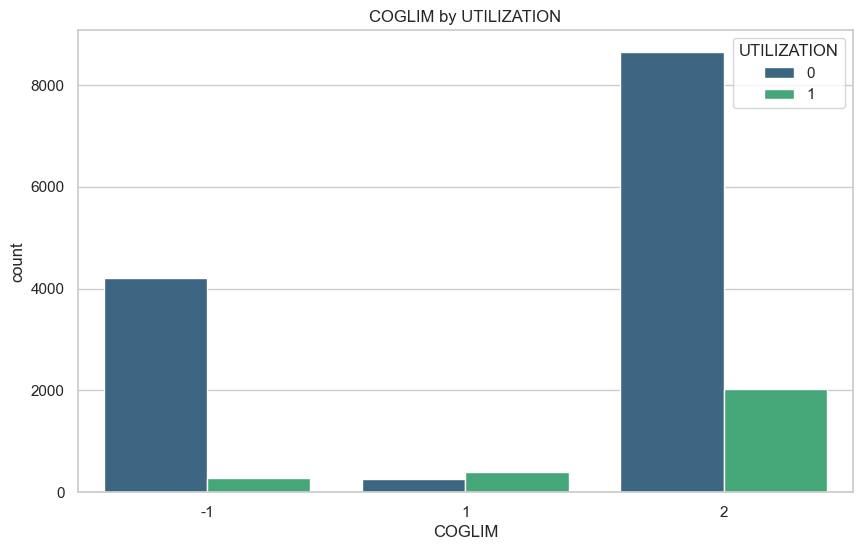

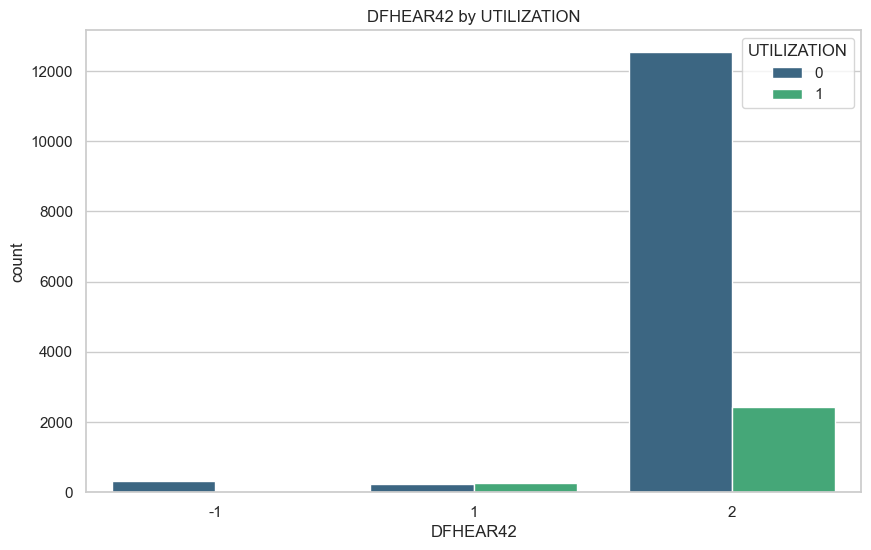

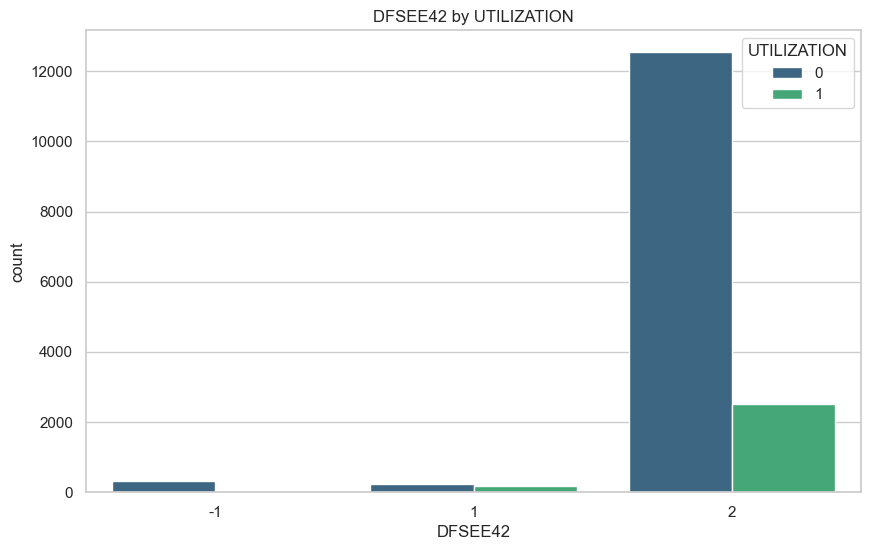

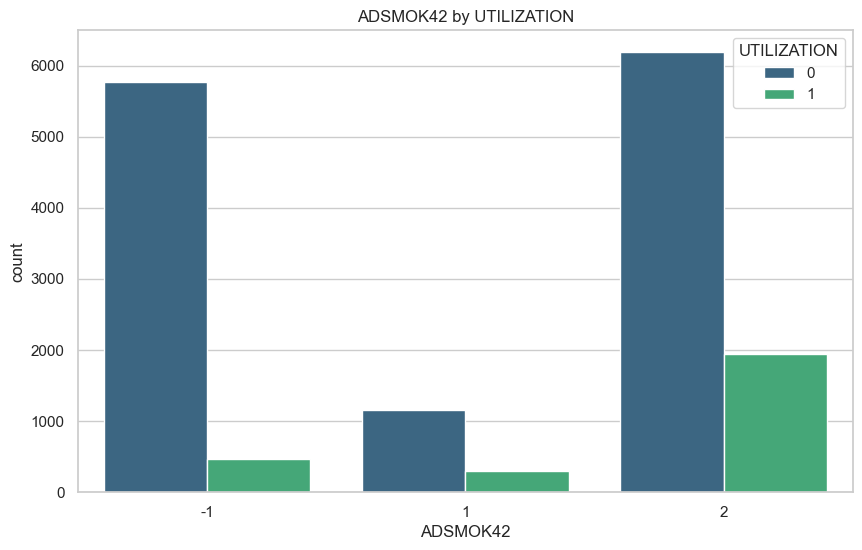

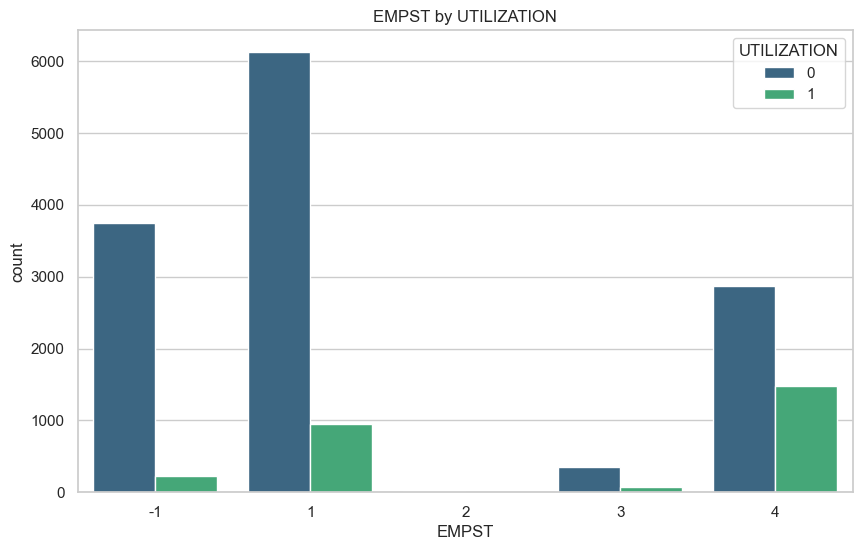

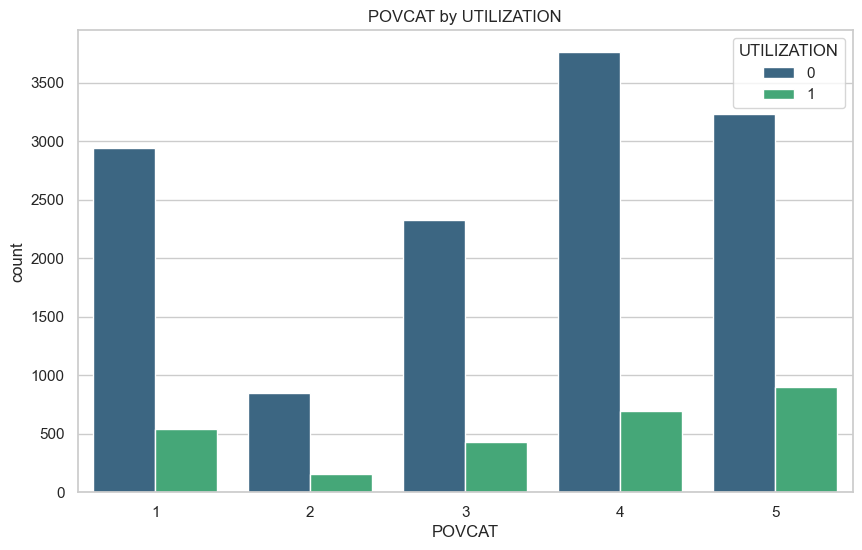

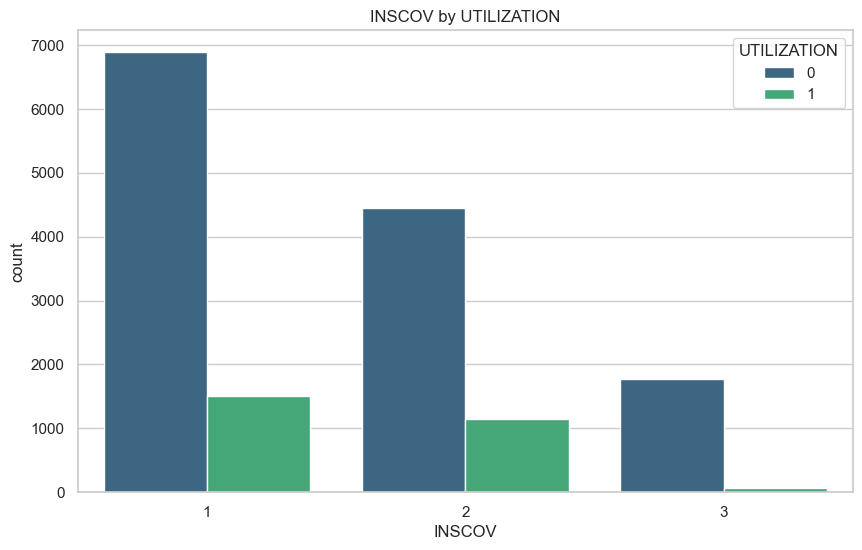

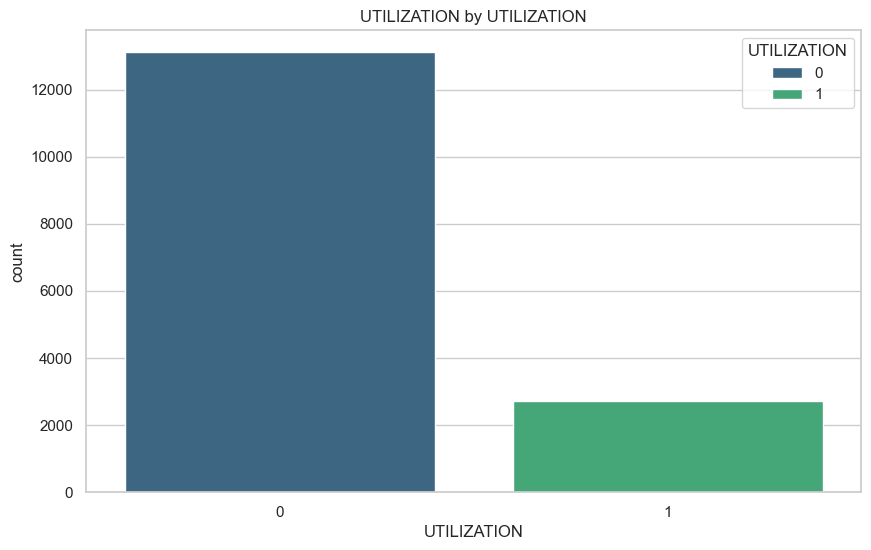

c:\Users\prsal\Desktop\DSC180A-Replication-Project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

In [42]:
ignore_cols = ['PHQ242', 'MCS42', 'PCS42', 'K6SUM42', 'AGE', 'HONRDC'] 
important_cols = [col for col in df_panel_19_reduced.columns if col not in ignore_cols]

for col in important_cols:
    data = sns.load_dataset("tips")

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_panel_19_reduced, x=col, hue="UTILIZATION", palette="viridis")

    # Customize plot
    plt.title(f"{col} by UTILIZATION")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend(title="UTILIZATION")

    # Show plot
    plt.show()


### End of Replication Part 01 -  EDA


-----
# Start of Replication Part 02 -  Model Development, and Fairness Evaluation

## There are **two** components to `Replication Project Part #02`
1. Training models without de-biasing, using IBM's tutorial
2. Training models without de-biasing, using your own model development techniques including (1) Feature Selection, (2) Encoding, (3) Binning Features, and other items 

#### We will now return to IBM AIF360's [Medical Expenditure Tutorial](https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb) 
_*Note that it is primarily Scikit-learn based_

* A reminder, you will need to fork [AIF360's repository](https://github.com/Trusted-AI/AIF360) into your own GitHub and access the notebook locally or via your method of choice
* AIF360's Repository can be found under: `AIF360`/`Examples`/tutorial_medical_expenditure.ipynb
* Ensure you have your `aif360` environment turned and activated using a miniconda prompt
* Use Jupyter Labs
* Refer to [Week 03](https://nanrahman.github.io/capstone-responsible-ai/weeks/03-Replication-Part-00/) content on the course Website to access the `Quickstart Guide`






### [3.](#Table-of-Contents) Model Development without Debiasing 


First, load all necessary packages

In [43]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

In [44]:
# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline


import requests
from bs4 import BeautifulSoup

import re

pd.set_option('display.max_columns', None)

### 3.1. Load data & create splits for learning/validating/testing model

In [45]:
panel19_train, panel19_val, panel19_test = MEPSDataset19().split([0.5, 0.8], shuffle=True)

In [46]:
MEPSDataset19().convert_to_dataframe()[0]

,AGE,RACE,PCS42,MCS42,K6SUM42,REGION=1,REGION=2,REGION=3,REGION=4,SEX=1,SEX=2,MARRY=1,MARRY=2,MARRY=3,MARRY=4,MARRY=5,MARRY=6,MARRY=7,MARRY=8,MARRY=9,MARRY=10,FTSTU=-1,FTSTU=1,FTSTU=2,FTSTU=3,ACTDTY=1,ACTDTY=2,ACTDTY=3,ACTDTY=4,HONRDC=1,HONRDC=2,HONRDC=3,HONRDC=4,RTHLTH=-1,RTHLTH=1,RTHLTH=2,RTHLTH=3,RTHLTH=4,RTHLTH=5,MNHLTH=-1,MNHLTH=1,MNHLTH=2,MNHLTH=3,MNHLTH=4,MNHLTH=5,HIBPDX=-1,HIBPDX=1,HIBPDX=2,CHDDX=-1,CHDDX=1,CHDDX=2,ANGIDX=-1,ANGIDX=1,ANGIDX=2,MIDX=-1,MIDX=1,MIDX=2,OHRTDX=-1,OHRTDX=1,OHRTDX=2,STRKDX=-1,STRKDX=1,STRKDX=2,EMPHDX=-1,EMPHDX=1,EMPHDX=2,CHBRON=-1,CHBRON=1,CHBRON=2,CHOLDX=-1,CHOLDX=1,CHOLDX=2,CANCERDX=-1,CANCERDX=1,CANCERDX=2,DIABDX=-1,DIABDX=1,DIABDX=2,JTPAIN=-1,JTPAIN=1,JTPAIN=2,ARTHDX=-1,ARTHDX=1,ARTHDX=2,ARTHTYPE=-1,ARTHTYPE=1,ARTHTYPE=2,ARTHTYPE=3,ASTHDX=1,ASTHDX=2,ADHDADDX=-1,ADHDADDX=1,ADHDADDX=2,PREGNT=-1,PREGNT=1,PREGNT=2,WLKLIM=-1,WLKLIM=1,WLKLIM=2,ACTLIM=-1,ACTLIM=1,ACTLIM=2,SOCLIM=-1,SOCLIM=1,SOCLIM=2,COGLIM=-1,COGLIM=1,COGLIM=2,DFHEAR42=-1,DFHEAR42=1,DFHEAR42=2,DFSEE42=-1,DFSEE42=1,DFSEE42=2,ADSMOK42=-1,ADSMOK42=1,ADSMOK42=2,PHQ242=-1,PHQ242=0,PHQ242=1,PHQ242=2,PHQ242=3,PHQ242=4,PHQ242=5,PHQ242=6,EMPST=-1,EMPST=1,EMPST=2,EMPST=3,EMPST=4,POVCAT=1,POVCAT=2,POVCAT=3,POVCAT=4,POVCAT=5,INSCOV=1,INSCOV=2,INSCOV=3,UTILIZATION
0,53.0,1.0,25.93,58.47,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,56.0,1.0,20.42,26.57,17.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,23.0,1.0,53.12,50.33,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1.0,-1.00,-1.00,-1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,27.0,0.0,-1.00,-1.00,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.

In [47]:

attributes = panel19_train.protected_attribute_names[0]

unprivileged = [{attributes: v} for v in
                       panel19_train.unprivileged_protected_attributes[0]]
privileged = [{attributes: v} for v in
                     panel19_train.privileged_protected_attributes[0]]

Following Code Cell is from [Medical Expenditure Tutorial](https://github.com/Dsilva019/AIF360/blob/main/examples/tutorial_medical_expenditure.ipynb)


In [48]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

In [49]:
describe(panel19_train, panel19_val, panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

In [50]:
panel19_train_metrics = BinaryLabelDatasetMetric(
        panel19_train,
        unprivileged_groups=unprivileged,
        privileged_groups=privileged)
dimpanct_panel19_train = MetricTextExplainer(panel19_train_metrics)

print(dimpanct_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


### 3.2. Learning a Logistic Regression (LR) classifier on original data

In [51]:
X_train = panel19_train
train_feat = X_train.features
train_labels = X_train.labels.ravel()
lrmodel = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=1))

lr_orig_panel19 = lrmodel.fit(train_feat, train_labels, **{'logisticregression__sample_weight': X_train.instance_weights})

In [52]:
from collections import defaultdict

def test(data, model, thresh_arr):
    metrics = defaultdict(list)
    try:
   
        probs = model.predict_proba(data.features)
        pos_ind = np.where(model.classes_ == data.favorable_label)[0][0]
    except AttributeError:
       
        probs = model.predict(data).scores
        pos_ind = 0
    
   
    for i in thresh_arr:
        dataset_pred = data.copy()
        dataset_pred.labels = (i < probs[:, pos_ind]).astype(np.float64)
        
        metric = ClassificationMetric(data, dataset_pred, unprivileged_groups=unprivileged, privileged_groups=privileged)

        metrics['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metrics['avg_odds_diff'].append(metric.average_odds_difference())
        metrics['disp_imp'].append(metric.disparate_impact())
        metrics['stat_par_diff'].append(metric.statistical_parity_difference())
        metrics['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metrics['theil_ind'].append(metric.theil_index())
    
    return metrics

In [53]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(data= panel19_val, model=lr_orig_panel19, thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

Following Code Cell is from [Medical Expenditure Tutorial](https://github.com/Dsilva019/AIF360/blob/main/examples/tutorial_medical_expenditure.ipynb)


In [54]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

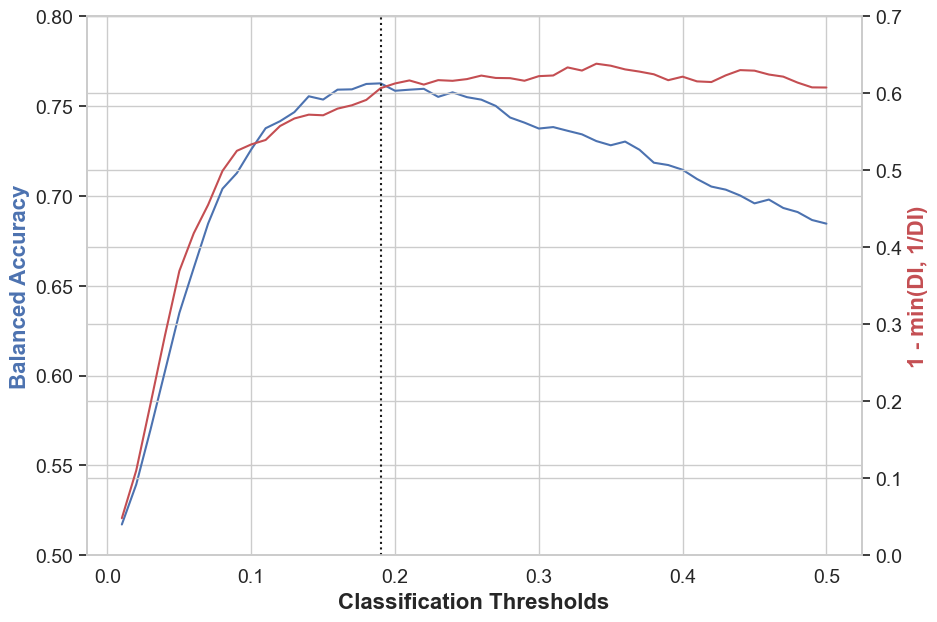

In [55]:
disp_imp = np.array(val_metrics['disp_imp'])
error = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     error , '1 - min(DI, 1/DI)')

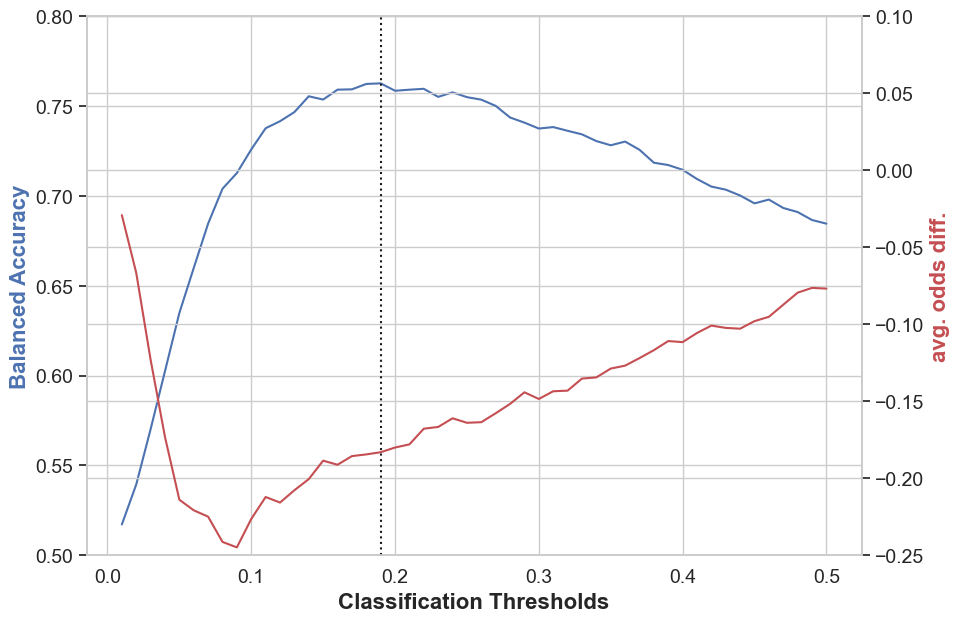

In [56]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

Following Code Cell is from [Medical Expenditure Tutorial](https://github.com/Dsilva019/AIF360/blob/main/examples/tutorial_medical_expenditure.ipynb)


In [57]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [58]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


### 3.3. Learning a Random Forest (RF) classifier on original data

In [59]:
# Original Data used to train Random Forest classifier model

dataset = panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

# Validating Random Forest classifier model

thresh_arr = np.linspace(0.01, 0.7, 100)
val_metrics = test(data=panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

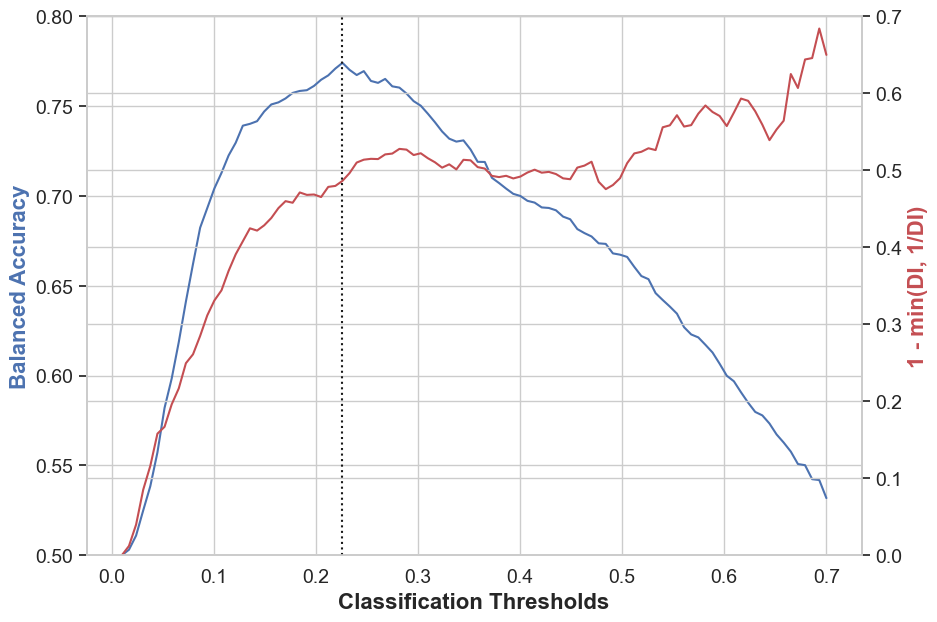

In [60]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

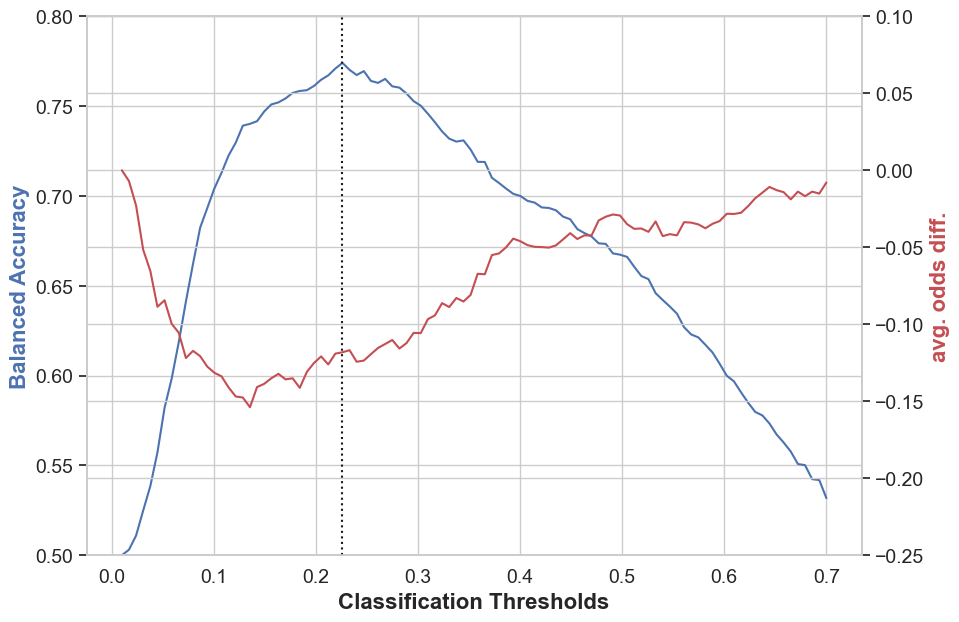

In [61]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

### Section 3 Write Up here

### Part-01: For **both** the logistic regression and random forest classifiers learned on the original data, please include explain the results of your fairness metrics. For _each_ metric result briefly describe what this value means in 1-2 sentences (is it fair, is it not fair? Why?)

**Fairness Metric Summary** 
* Threshold corresponding to Best balanced accuracy:
* Best balanced accuracy: 
* Corresponding 1-min(DI, 1/DI) value: 
* Corresponding average odds difference value: 
* Corresponding statistical parity difference value: 
* Corresponding equal opportunity difference value:
* Corresponding Theil index value:

### Part-02: Please write one paragraph for each question.
1. How can we determine which metrics to use, given our data and use case? You can refer to [Course material](https://nanrahman.github.io/capstone-responsible-ai/weeks/06-Fairness-Assessments/), online research and Guidance provided by [AIF360](http://aif360.mybluemix.net/resources#)
2. When you have competing fairness metrics, how to pick which to prioritize?
3. What do you do when you encounter different definitions for similar metrics?
4. Based on this, which model and fairness metric appears the best to proceed with?

### Part-01: Logistic Regression Fairness Metric Summary
* Threshold corresponding to Best balanced accuracy: 0.19
* Best balanced accuracy: 0.7627
* Corresponding 1-min(DI, 1/DI) value: 0.6066
* Corresponding average odds difference value: -0.1831
* Corresponding statistical parity difference value: -0.2643
* Corresponding equal opportunity difference value: -0.1608
* Corresponding Theil index value: 0.0936


The threshold corresponding to Best Balanced accuracy means it is the point at which the highest balanced accuracy was reached. A balanced threshold means that the classifier does not have an inherit bias towards a certain class, for this case the best balanced accuracy was achieved with a threshold of 0.19

The balanced accuracy is the average of the specificity and sensitivity. With a value of 0.7627 means that the model has a good ability to classify positive and negative classes correctly. With this accuracy implies that it could be a fair model given that its consistent for all groups.

Corresponding 1-min(DI, 1/DI) value tells us the disparity in the predicted outcomes between groups. Since are value is 0.6066 which is relatively a bit far from a value of 1, a value of 1 impless complete fairness, this means the logistic regression model has some disparity implying that its predictions may not be fully equitable.

The average odds difference is the average difference between false positive rate and true positive rate between privileged and unprivileged groups. With a value of -0.1831 it means that our model may favor one group over the other since a value of 0 indicates fairness.

The statistical parity difference is the computed difference of the rate of favorable outcomes that the privileged and unprivileged groups got. A value of 0 indicates that the model is fair but since the value is -0.2643 it means that there is some bias in that one group gets more favorable outcomes than the other.

Equal opportunity difference corresponds to the computed difference of the true positive rates between privileged and unprivileged groups. Since the value is negative this implies that one group might be biased towards getting more positive classifications.

The Theil index is the generalized entropy of the benefit for all individuals in the data, it measures the inquality when it comes to benefit allocation for individuals. With the value 0.0936 it implies our model there a small degree of inequality since a value of 0 means that the model is equal.

### Part-02 Summary Questions

1. Due to the sensitive nature of healthcare data and the potential impact on unprivileged and privileged groups metrics that reflect both individual and group fairness are highly important. Additionally, metrics that measure the positive outcomes of different groups. As a result, metrics such as equal opportunity difference and statistical parity are useful since they ensure individuals from all racial/economic backgrounds have an equal chance of receiving positive outcomes/classifications. Meaning they have an equal chance of receiving healthcare when they need it. Other useful metrics are average odds difference and the Theil index because they measure any disparity in outcome distributions including any inequality. These measures would be important when it comes to fairness in patient recommendations. These metrics would provide a thorough measure of both individual and group fairness which is important in healthcare. By ensuring there is individual and group fairness it would ensure there is no unequal treatment of patients due to racial or economic bias.

2. If there are competing fairness metrics then the way to pick which metrics to prioritize depends on the specific healthcare needs. For example, if we want to make sure that minority groups or other unprivileged groups are not underrepresented in positive outcomes/classifications then metrics such equal opportunity difference should be priotized. But other needs may be wanted as well such as maintaining a balance between predictions when it comes to all racial groups without certain bias towards one group or groups then metrics such as statistical parity or average odds difference should be prioritized. The prioritization of metrics highly depends on the specific ethical needs and potential impact on patients. Properizing metrics that align with the specific ethical needs and future potential impact on the patients which should be stated before the model-making process will help create a model that is fair and unbiased for its intended purpose.

3. If there are different definitions for similar metrics then it is important to understand how each definition fits within the context of the model and the data. In our instance which is a healthcare utilization model metric definitions that align best with the fairness goals when it comes to patient care. For example, if the main goal is to ensure all racial or privileged/unprivileged groups have near equal or equal chances of being identified for care management then metrics like equal opportunity difference should be used since they measure the true positive rates across groups. In a different example, if ensuring that positive outcomes for different groups are balanced then metrics such as statistical parity difference should be prioritized. As a result, understanding what goals are being set and how they fit with the context of the model and data can help us understand what metric definitions are most useful despite there being multiple definitions for similar metrics.

### [4.](#Table-of-Contents) Additional Model Development



### 4.1A Load data & create splits for learning/validating/testing model

In [62]:
# define a custom preprocessing function to use
from aif360.datasets.meps_dataset_panel19_fy2015 import default_preprocessing

def custom_preprocessing(df):
    # call default preprocessing function first
    df = default_preprocessing(df)


    # now make additional processing:
    ## BINNING:
    # MARRY = [2,3,4, 7, 8, 9, 10] groups have small populations
    # 2 = widowed, 3 = divorced, 4 = separated, 5 = never married
    # 7 = married in round, 8 married in round, 9 divorced in round, 10 separated in round
    # ADD BIN = [2, 3, 4, 5] = 'SINGLE'
    # ADD BIN = [7, 8, 9, 10] = 'OTHER'

    # EMPST (employment status)
    # groups = [2, 3] have small populations
    # [1, 2, 3] = 'EMPLOYED'
    # [-1, 4] = 'UNEMPLOYED'

    # The following columns will:
    # CHHDDX (chronic heart disease diagnosis)
    # ANGIDX (angina diagnosis)
    # MIDX (heart attack)
    # OHRTDX (other heart disease)
    # STRKDX (stroke)
    # EMPHDX (emphysema)
    # CHBRON (chronic bronchitis last 12 months)
    # CHOLDX (high cholesterol)
    # CANCERDX (cancer)
    # ARTHDX (arthritis)
    # ADHDADDX (adhadadd)
    # PREGNT (pregant)
    # WLKLIM (limitation in physical functioning)
    # ACTLIM (any limitation)
    # SOCLIM (social limitations)
    # COGLIM (cognitive limitations)
    # DFHEAR42 (serious difficulty hearing)
    # DFSEE42 (serious difficulty seeing)
    # ADSMOKE42 (currently smoke)
    for col in df.columns:
        if col == 'MARRY':
            marry_map = {2: 'single', 3:'single', 4:'single', 5:'single',
                         7: 'other', 8: 'other', 9: 'other', 10: 'other'}
            df[col] = df[col].apply(lambda col: marry_map.get(col, col))
        elif col == 'EMPST':
            employed_map = {1: 'employed', 2:'employed', 3:'employed',
                            -1: 'unemployed', 4:'unemployed'}
            df[col] = df[col].apply(lambda col: employed_map.get(col, col))
        elif col in [
            "CHHDDX", "ANGIDX", "MIDX", "OHRTDX", "STRKDX", "EMPHDX", "CHBRON",
            "CHOLDX", "CANCERDX", "ARTHDX", "ADHDADDX", "PREGNT", "WLKLIM",
            "ACTLIM", "SOCLIM", "COGLIM", "DFHEAR42", "DFSEE42", "ADSMOKE42"
        ]:
            df[col] = df[col].apply(lambda col: col if col != 1 else 2)
        print(col)

    return df

In [63]:
# # define a custom preprocessing function to use
# from aif360.datasets.meps_dataset_panel19_fy2015 import default_preprocessing

# def custom_preprocessing(df):
#     # call default preprocessing function first
#     print(df.columns)
#     df = default_preprocessing(df)
#     print()
#     print(df.columns)
#     # now make additional processing:
#     ## BINNING:
#     # COlumn: MARRY has values [2,3,4, 7, 8, 9, 10] with small populations
#     # we will bin these togehter using the following approach:
#     # 2 = widowed, 3 = divorced, 4 = separated, 5 = never married
#     # 7 = married in round, 8 married in round, 9 divorced in round, 10 separated in round
#     # ADD BIN = [2, 3, 4, 5] = 'SINGLE'
#     # ADD BIN = [7, 8, 9, 10] = 'OTHER'
#     marry_map = {2: 'single', 3:'single', 4:'single', 5:'single',
#                          7: 'other', 8: 'other', 9: 'other', 10: 'other'}
#     df['MARRY'] = df['MARRY'].apply(lambda col: marry_map.get(col, col))
    
#     # Column: EMPST (employment status) has values [2, 3] with small populations
#     # we will bin these together using the following approach:
#     # [1, 2, 3] = 'EMPLOYED'
#     # [-1, 4] = 'UNEMPLOYED'
#     employed_map = {1: 'employed', 2:'employed', 3:'employed',
#                     -1: 'unemployed', 4:'unemployed'}
#     df['EMPST'] = df['EMPST'].apply(lambda col: employed_map.get(col, col))

#     # The following columns will group -1 and 2 together since they both can be interpretted as 'No':
#     # CHHDDX (chronic heart disease diagnosis)
#     # ANGIDX (angina diagnosis)
#     # MIDX (heart attack)
#     # OHRTDX (other heart disease)
#     # STRKDX (stroke)
#     # EMPHDX (emphysema)
#     # CHBRON (chronic bronchitis last 12 months)
#     # CHOLDX (high cholesterol)
#     # CANCERDX (cancer)
#     # ARTHDX (arthritis)
#     # ADHDADDX (adhadadd)
#     # PREGNT (pregant)
#     # WLKLIM (limitation in physical functioning)
#     # ACTLIM (any limitation)
#     # SOCLIM (social limitations)
#     # COGLIM (cognitive limitations)
#     # DFHEAR42 (serious difficulty hearing)
#     # DFSEE42 (serious difficulty seeing)
#     # ADSMOKE42 (currently smoke)
#     for col in ["CHHDDX", "ANGIDX", "MIDX", "OHRTDX", "STRKDX", "EMPHDX", "CHBRON",
#             "CHOLDX", "CANCERDX", "ARTHDX", "ADHDADDX", "PREGNT", "WLKLIM",
#             "ACTLIM", "SOCLIM", "COGLIM", "DFHEAR42", "DFSEE42", "ADSMOKE42"]:
#         df[col] = df[col].apply(lambda col: col if col != 1 else 2)
    
#     return df

In [64]:
panel19_train_metrics = BinaryLabelDatasetMetric(
        panel19_train,
        unprivileged_groups=unprivileged,
        privileged_groups=privileged)
dimpanct_panel19_train = MetricTextExplainer(panel19_train_metrics)

print(dimpanct_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


### 4.1B Utilize findings from your EDA to complete any additional mmodel development

In [65]:
# Examples:

# Feature selection 
# encoding
# binning categorical features

# Feel free to use the codebook from MEPS to explore other variables

# here we apply the custom preprocessing function to bin categories together
df_custom_processed = MEPSDataset19(custom_preprocessing=custom_preprocessing)

panel19_train, panel19_val, panel19_test = df_custom_processed.split([0.5, 0.8], shuffle=True)

attributes = panel19_train.protected_attribute_names[0]

unprivileged = [{attributes: v} for v in
                       panel19_train.unprivileged_protected_attributes[0]]
privileged = [{attributes: v} for v in
                     panel19_train.privileged_protected_attributes[0]]

DUID
PID
DUPERSID
PANEL
FAMID31
FAMID42
FAMID53
FAMID15
FAMIDYR
CPSFAMID
FCSZ1231
FCRP1231
RULETR31
RULETR42
RULETR53
RULETR15
RUSIZE31
RUSIZE42
RUSIZE53
RUSIZE15
RUCLAS31
RUCLAS42
RUCLAS53
RUCLAS15
FAMSZE31
FAMSZE42
FAMSZE53
FAMSZE15
FMRS1231
FAMS1231
FAMSZEYR
FAMRFPYR
REGION31
REGION42
REGION
REGION15
REFPRS31
REFPRS42
REFPRS53
REFPRS15
RESP31
RESP42
RESP53
RESP15
PROXY31
PROXY42
PROXY53
PROXY15
INTVLANG
BEGRFM31
BEGRFY31
ENDRFM31
ENDRFY31
BEGRFM42
BEGRFY42
ENDRFM42
ENDRFY42
BEGRFM53
BEGRFY53
ENDRFM53
ENDRFY53
ENDRFM15
ENDRFY15
KEYNESS
INSCOP31
INSCOP42
INSCOP53
INSCOP15
INSC1231
INSCOPE
ELGRND31
ELGRND42
ELGRND53
ELGRND15
PSTATS31
PSTATS42
PSTATS53
RURSLT31
RURSLT42
RURSLT53
AGE31X
AGE42X
AGE
AGE15X
AGELAST
DOBMM
DOBYY
SEX
RACEV1X
RACE
RACEAX
RACEBX
RACEWX
RACETHX
HISPANX
HISPNCAT
MARRY31X
MARRY42X
MARRY
MARRY15X
SPOUID31
SPOUID42
SPOUID53
SPOUID15
SPOUIN31
SPOUIN42
SPOUIN53
SPOUIN15
EDUYRDG
EDUCYR
HIDEG
EDRECODE
FTSTU31X
FTSTU42X
FTSTU
FTSTU15X
ACTDTY31
ACTDTY42
ACTDTY
HONRDC31
HON

In [66]:
describe(panel19_train, panel19_val, panel19_test)

#### Training Dataset shape

(7915, 112)


#### Validation Dataset shape

(4749, 112)


#### Test Dataset shape

(3166, 112)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=6', 'MARRY=other', 'MARRY=single', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=2', 'ARTHTYPE=-1', 'ARTHTYPE=1', 'ARTHTYPE=2', 'ARTHTYPE=3', 'ASTHDX=1', 'ASTHDX=2', 'ADHDADDX=-1', 'ADHDADDX=2', 'PREGNT=-1', 'PREGNT=2', 'WLKLIM=-1', 'WLKLIM=2', 'ACTLIM=-1', 'ACTLI

### 4.2. Learning a Logistic Regression (LR) classifier on original data

In [67]:
# Use the same methods from Section 3

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

X_train = panel19_train
train_feat = X_train.features
train_labels = X_train.labels.ravel()

X_val = panel19_val
val_feat = X_val.features
val_labels = X_val.labels.ravel()


pipeline = make_pipeline(
    StandardScaler(), # z-score normalize our dataset vaues
    PCA(), # principle component analysis to reduce chance of multicolinearity
    LogisticRegression()
)


# Our original parameter grid we ran gridsearch on
# param_grid = {
#     'pca__n_components': [20, 40, 60, 80, 100, 120],
#     'logisticregression__C': [0.1, 1, 10, 20, 40],
#     'logisticregression__penalty': ['l1', 'l2'],
#     'logisticregression__solver': ['liblinear'],
#     'logisticregression__max_iter': [100, 200, 300]
# }

### cheating so we don't have to have a long wait again:
# Best Parameters: {'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'pca__n_components': 80}
# Best Cross-Validation Score: 0.6855497528999156
param_grid = {'logisticregression__C': [10], 
              'logisticregression__max_iter': [100], 
              'logisticregression__penalty': ['l2'], 
              'logisticregression__solver': ['liblinear'], 
              'pca__n_components': [80]
              }

grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           scoring='balanced_accuracy',
                           cv=5) 
grid_search.fit(train_feat, train_labels)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'pca__n_components': 80}
Best Cross-Validation Score: 0.6672880172262624


In [68]:
val_metrics = test(X_val, best_model, thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1842
Best balanced accuracy: 0.7597
Corresponding 1-min(DI, 1/DI) value: 0.5917
Corresponding average odds difference value: -0.2250
Corresponding statistical parity difference value: -0.2858
Corresponding equal opportunity difference value: -0.2236
Corresponding Theil index value: 0.0967


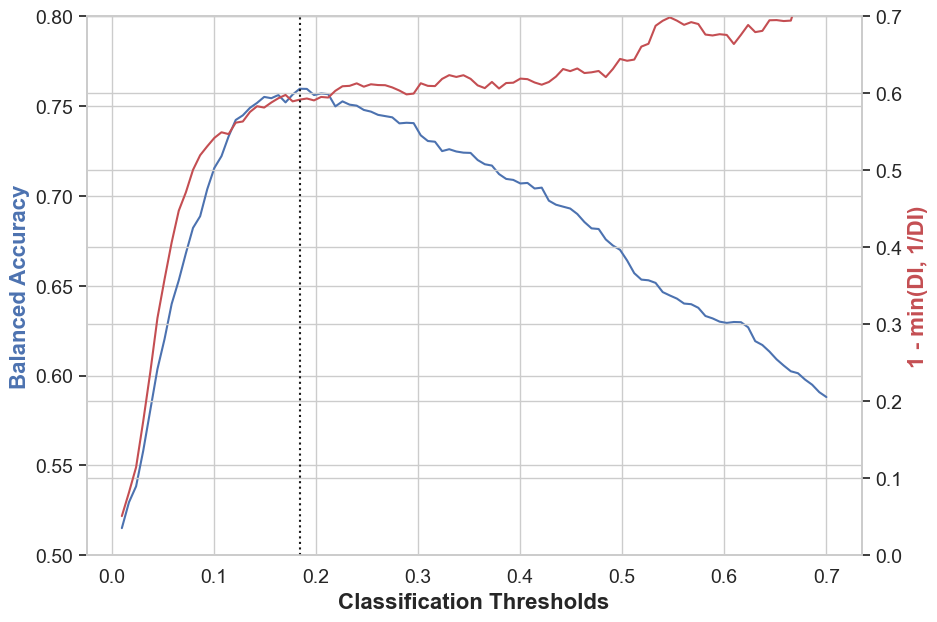

In [69]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

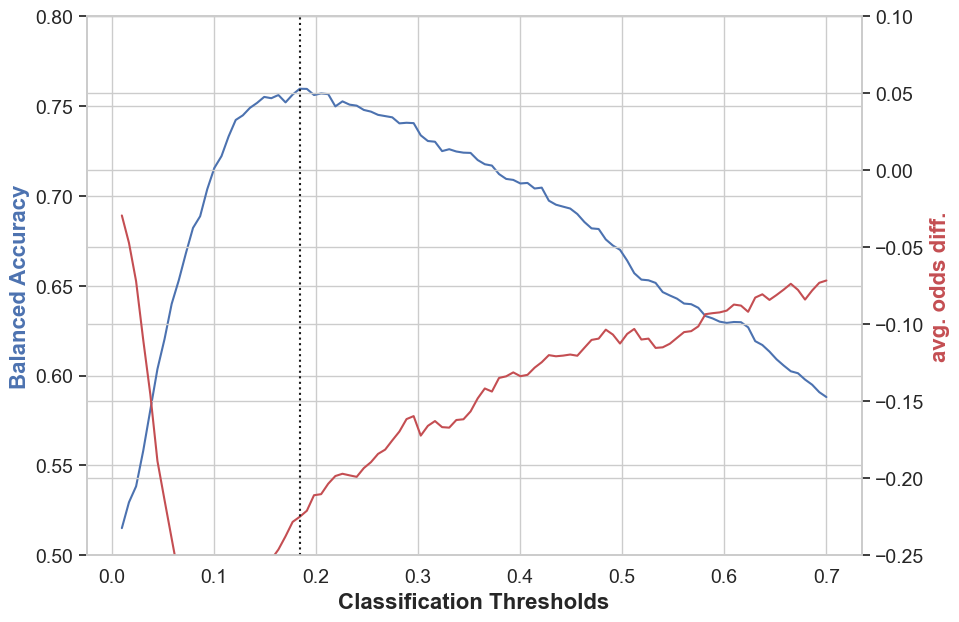

In [70]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

### 4.3. Learning a Random Forest (RF) classifier on original data

In [71]:
# Use the same methods from Section 3
X_train = panel19_train
train_feat = X_train.features
train_labels = X_train.labels.ravel()

X_val = panel19_val
val_feat = X_val.features
val_labels = X_val.labels.ravel()

pipeline = make_pipeline(
    StandardScaler(),  # Z-score normalization
    PCA(),  # Principal component analysis
    RandomForestClassifier()
)

# Our original parameter grid we ran gridsearch on
# param_grid = {
#     'pca__n_components': [60, 80, 100],
#     'randomforestclassifier__max_depth': [20, 30, None],
#     # 'randomforestclassifier__min_samples_split': [2, 5, 10],
#     # 'randomforestclassifier__min_samples_leaf': [1, 2, 4]
#    'randomforestclassifier__n_estimators': [100, 250, 500, 1000]
# }

### cheating so we don't have to have a long wait again:
# Best Parameters: {'pca__n_components': 60, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 1000}
# Best Cross-Validation Score: 0.6668093098980189


param_grid = {
    'pca__n_components': [60], 
    'randomforestclassifier__max_depth': [20],
    'randomforestclassifier__min_samples_split': [5],
    'randomforestclassifier__min_samples_leaf': [1],
    'randomforestclassifier__n_estimators': [500]
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring='balanced_accuracy',
    cv=5
)

grid_search.fit(train_feat, train_labels)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'pca__n_components': 60, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 500}
Best Cross-Validation Score: 0.644352802129462


In [72]:
val_metrics = test(X_val, best_model, thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1982
Best balanced accuracy: 0.7524
Corresponding 1-min(DI, 1/DI) value: 0.4219
Corresponding average odds difference value: -0.1193
Corresponding statistical parity difference value: -0.1955
Corresponding equal opportunity difference value: -0.0938
Corresponding Theil index value: 0.0940


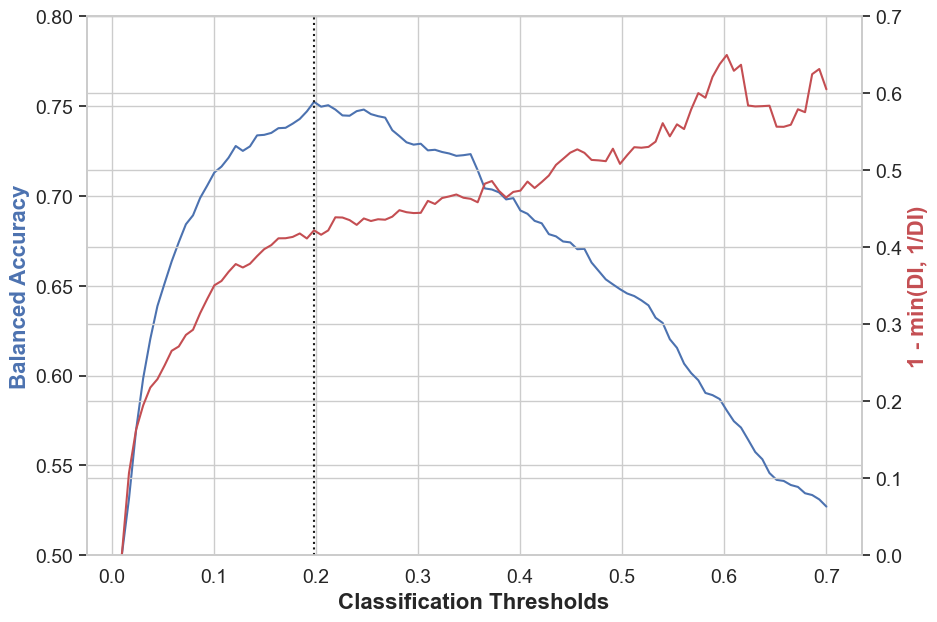

In [73]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

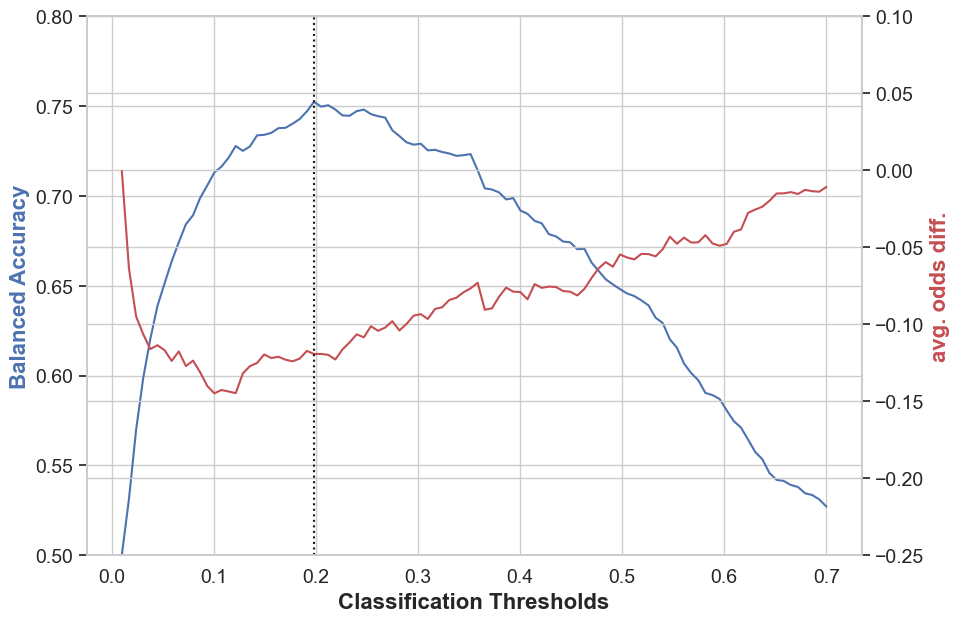

In [74]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

### Section 4 Write Up here

**1. For both the logistic regression and random forest classifiers learned on the original data, please include the results of your fairness metrics. For _each_ metric result briefly describe (1-2 sentences) if you saw any differences from your results in Part 3, and what that might mean.**

_Fairness Metrics_
   * Threshold corresponding to Best balanced accuracy:
   * Best balanced accuracy: 
   * Corresponding 1-min(DI, 1/DI) value: 
   * Corresponding average odds difference value: 
   * Corresponding statistical parity difference value: 
   * Corresponding equal opportunity difference value:
   * Corresponding Theil index value:
    
**2. Based on this, would you make any recommendations during model development? Does it change which model and fairness metric would be the best to proceed with?** (Please write at least one paragraph)

1) If we consider both of our models after binning together categories, performing PCA, and even trying to perform cv-gridsearch, we saw a significant decrease in model accuracy and worsening in each fairness metric. More specifically, the 1-min(DI, 1/DI), average odds difference value, statistical parity difference value, equal opportunity difference value, and theil index value all increased in magnitude indicating that they performed worse. Intuitively, this makes sense because by binning together categories we are generalizing the data points in our training data; making our model less fair to population groups that are underrepresented.


2) Based on these findings, I think during model development we need to take a different approach. Since our models did worse when we binned together categories, which inevitably generalized underrepresented groups, we should try to do the opposite. One approach could be to focus on training dataset and oversample the underrepresented groups, we could also under-sample the overrepresented groups. 

In [75]:
#nothing


### End of Replication Part 02 -  Model Development and Fairness Evaluation

----


#### _Items below will be updated as course progress_



### [5.](#Table-of-Contents) Bias Mitigation

### [6.](#Table-of-Contents) Results Summary

### [7.](#Table-of-Contents) Explainability

### [8.](#Table-of-Contents) Conclusion & Discussion